In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
#sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [2]:
probs = pd.read_csv("./logit_probabilities_70_30_final.csv", comment = "#")

In [3]:
probs = probs.sort_values(["feedname", "taxon", "probability"]).drop_duplicates(["feedname", "taxon"], keep = "last")

In [4]:
probs = probs[probs["probability"] >= 0.50].reset_index(drop=True)

In [5]:
probs = probs[probs["taxon"].isin(["Engraulis_ringens", "Salmo_salar", 
                           "Sardina_pilchardus", "Scomber_scombrus", 
                           "Micromesistius_poutassou"])].sort_values(["taxon", "feedname"]).reset_index(drop=True)

In [7]:
probs[["feedname", "taxon"]].to_csv("/mnt/c/Users/Nicolas Locatelli/Downloads/samp_by_taxon_matrix.csv", index = False)

In [9]:
!tail -n+3 MixD.ed0.lca | cut -f1-2 > MixD.lca

In [29]:
tmp = pd.read_csv("MixD.lca", sep = "\t", header = None)
tmp[0] = tmp[0].str.split(":", n = 1, expand = True)[0]

In [25]:
rlens = pd.read_csv("MixD.readlengths", sep = " ", header = None)
rlens[0] = rlens[0].str.replace("@", "")
rlens["len"] = rlens.sort_values(0).groupby([0])[1].transform('sum')
rlens = rlens.drop_duplicates(0).reset_index(drop=True)

In [33]:
tmp = tmp.merge(rlens[[0, "len"]], how = "left", on = 0)

In [38]:
bases = tmp.copy()
bases["sum"] = bases.groupby([1])["len"].transform('sum')
bases = bases.drop_duplicates(1)

In [41]:
bases["read_proportion"] = bases["sum"] / bases["sum"].sum()

In [6]:
test = pd.read_csv("./MixE.csv")

In [7]:
keys = pd.read_csv("mixes_for_ngsLCA_tests.csv")

In [8]:
rlens = test.copy()
rlens["len"] = rlens.groupby(["TaxName"])["TotalBases"].transform('sum')
rlens = rlens.drop_duplicates("TaxName").reset_index(drop=True)
rlens["len"] = rlens["len"]/ rlens["len"].sum()

In [9]:
samplemap = keys.drop_duplicates("Run")
samplemap["sample"] = samplemap.Run

/tmp/ipykernel_71/2038103491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samplemap["sample"] = samplemap.Run


In [11]:
keys

,Mix,Run,Constituent,Proportion,Bases,Notes,Avg Read Length
0,MixA,SRR28213561,Salmo_salar,0.047619,10000000,Balanced,147.2
1,MixA,SRR2174369,Salmo_salar,0.047619,10000000,Balanced,98.9
2,MixA,SRR2174357,Salmo_salar,0.047619,10000000,Balanced,98.6
3,MixA,ERR13511128,Salmo_trutta,0.047619,10000000,Balanced,148.3
4,MixA,ERR13511248,Salmo_trutta,0.047619,10000000,Balanced,148.2
...,...,...,...,...,...,...,...
239,MixH,T_albacares,Thunnus_albacares,0.058275,50000000,"Very unbalanced fish, many species",NaN
240,MixH,T_luscus,Trisopterus_luscus,0.001166,1000000,"Very unbalanced fish, many species",NaN
241,MixH,SRR5483576,Thunnus_thynnus,0.005828,5000000,"Very unbalanced fish, many species",NaN
242,MixH,T_trachurus,Trachurus_trachurus,0.011655,10000000,"Very unbalanced fish, many species",NaN


In [12]:
import pandas as pd
from io import StringIO

# Load Mash distances
df = pd.read_csv("alldists.tsv", sep="\t", header=None,
                 names=["species1", "species2", "distance", "shared", "pvalue"])

# Get unique species names
species = sorted(set(df["species1"]).union(set(df["species2"])))
species_clean = [s.replace(".fa.gz", "").replace("./reference_genomes/", "") for s in species]

# Initialize distance matrix
dist_matrix = pd.DataFrame(0.0, index=species_clean, columns=species_clean)

# Fill the matrix with Mash distances
for _, row in df.iterrows():
    s1 = row["species1"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    s2 = row["species2"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    dist_matrix.loc[s1, s2] = row["distance"]
    dist_matrix.loc[s2, s1] = row["distance"]

In [13]:
dist_matrix_subset = dist_matrix.reset_index(drop=False)

In [14]:
perc_correct = []
closest = []
taxa = []
for sp in ["Scomber_japonicus"]:
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap["sample"] = mismap["sample"].str.rsplit("_", expand = True, n = 1)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]
    taxa = taxa + [sp]
perc_correct = np.array(perc_correct)
closest = np.array(closest)

In [20]:
mismap["TotalBases"][mismap["Constituent"] == "Scomber_colias"].sum() / totaltospecies

0.21057996270606047

In [15]:
correctlymapped

4097153

In [73]:
perc_correct = []
closest = []
taxa = []
for sp in set(keys["Constituent"][keys["Mix"] == "MixE"].tolist()):
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap["sample"] = mismap["sample"].str.rsplit("_", expand = True, n = 1)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]
    taxa = taxa + [sp]
perc_correct = np.array(perc_correct)
closest = np.array(closest)

In [134]:
perc_correct = []
closest = []
taxa = []
for sp in ["Clupea_harengus"]:
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap["sample"] = mismap["sample"].str.rsplit("_", expand = True, n = 1)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]
    taxa = taxa + [sp]
perc_correct = np.array(perc_correct)
closest = np.array(closest)

/tmp/ipykernel_124/3076865690.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test["R2_AvgQual"][test["TaxName"] == sp.replace("_", " ")]


<Axes: xlabel='R2_AvgQual', ylabel='Density'>

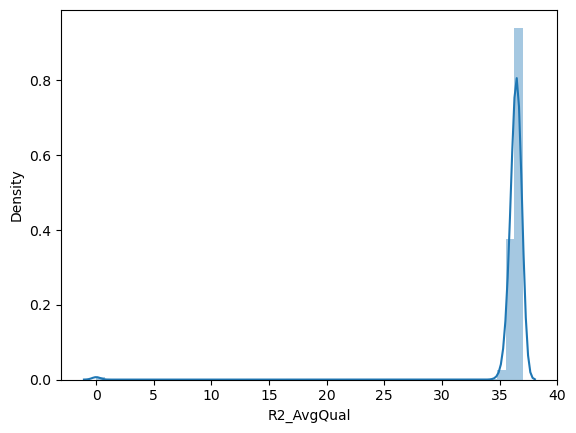

In [135]:
sns.distplot(test["R2_AvgQual"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))])

In [137]:
mismap

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance,R1_Length,R1_Matches,R1_Insertions,...,R1_AvgQual,R2_Length,R2_Matches,R2_Insertions,R2_Deletions,R2_Softclips,R2_Hardclips,R2_AvgQual,sample,Constituent
0,A_sapidissima_E00526:585:HJLFCCCX2:6:1114:1631...,7950,Clupea harengus,species,125,0.2080,unpaired,125,0,0,...,39.32,0,0,0,0,0,0,0.0,A_sapidissima,Alosa_sapidissima
1,B_patronus_SRR21844101.123497.2,7950,Clupea harengus,species,148,0.5203,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
2,B_patronus_SRR21844101.182355.2,7950,Clupea harengus,species,39,1.0000,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
3,B_patronus_SRR21844101.190457.1,7950,Clupea harengus,species,149,0.6510,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
4,B_patronus_SRR21844101.351274.1,7950,Clupea harengus,species,149,0.5973,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,Z_faber_E00526:585:HJLFCCCX2:6:1221:15727:3313,7950,Clupea harengus,species,148,0.2365,unpaired,148,0,0,...,40.15,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber
542,Z_faber_E00526:585:HJLFCCCX2:6:2102:12976:11171,7950,Clupea harengus,species,125,0.2240,unpaired,125,0,0,...,40.36,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber
543,Z_faber_E00526:585:HJLFCCCX2:6:2108:12510:20243,7950,Clupea harengus,species,123,0.2764,unpaired,123,0,0,...,40.03,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber
544,Z_faber_E00526:585:HJLFCCCX2:6:2121:6431:32812,7950,Clupea harengus,species,149,0.3356,unpaired,149,0,0,...,40.14,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber


/tmp/ipykernel_124/1944317509.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mismap["R1_AvgQual"])


<Axes: xlabel='R1_AvgQual', ylabel='Density'>

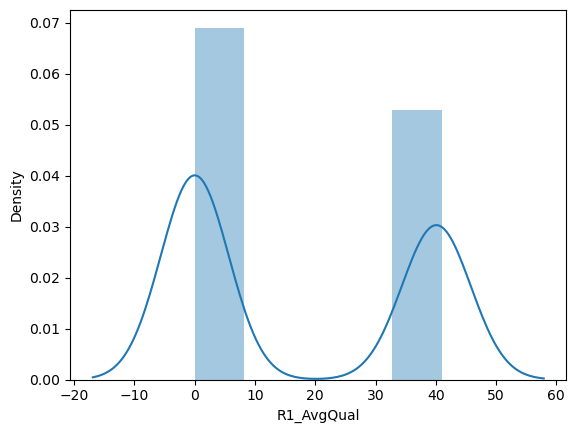

In [136]:
sns.distplot(mismap["R1_AvgQual"])

In [115]:
mismap

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance,R1_Length,R1_Matches,R1_Insertions,...,R1_AvgQual,R2_Length,R2_Matches,R2_Insertions,R2_Deletions,R2_Softclips,R2_Hardclips,R2_AvgQual,sample,Constituent
0,A_marinus_A00738:341:H7VHNDSX3:4:1246:9326:3959,7962,Cyprinus carpio,species,297,0.2685,same,149,1,0,...,36.76,148,0,0,1,118,0,36.92,A_marinus,Ammodytes_marinus
1,A_rochei_E00526:585:HJLFCCCX2:6:1112:23906:44064,7962,Cyprinus carpio,species,277,0.2027,same,148,0,2,...,40.15,129,0,0,0,103,0,39.26,A_rochei,Auxis_rochei
2,A_rochei_E00526:585:HJLFCCCX2:6:2214:5842:30703,7962,Cyprinus carpio,species,28,1.0000,unpaired,0,0,0,...,0.00,28,0,0,0,0,99,40.25,A_rochei,Auxis_rochei
3,A_sapidissima_E00526:585:HJLFCCCX2:6:1119:2307...,7962,Cyprinus carpio,species,64,1.0000,same,29,0,0,...,40.17,35,0,0,0,0,78,39.51,A_sapidissima,Alosa_sapidissima
4,B_patronus_SRR21844101.156926.2,7962,Cyprinus carpio,species,89,0.5393,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.00,B_patronus,Brevoortia_patronus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233,Z_faber_E00526:585:HJLFCCCX2:6:2201:6492:37172,7962,Cyprinus carpio,species,148,0.1824,unpaired,0,0,0,...,0.00,148,0,0,0,121,0,40.30,Z_faber,Zeus_faber
3234,Z_faber_E00526:585:HJLFCCCX2:6:2203:27986:9642,7962,Cyprinus carpio,species,27,1.0000,unpaired,0,0,0,...,0.00,27,0,0,0,0,95,40.33,Z_faber,Zeus_faber
3235,Z_faber_E00526:585:HJLFCCCX2:6:2208:17584:16762,7962,Cyprinus carpio,species,148,0.2162,unpaired,0,0,0,...,0.00,148,0,0,0,116,0,39.68,Z_faber,Zeus_faber
3236,Z_faber_E00526:585:HJLFCCCX2:6:2212:25672:49900,7962,Cyprinus carpio,species,47,0.8936,unpaired,47,3,2,...,40.36,0,0,0,0,0,0,0.00,Z_faber,Zeus_faber


In [120]:
mismap.value_counts("R1_AvgQual")

R2_AvgQual
0.00     745
37.00    129
36.76    111
36.84    108
36.68    105
        ... 
39.18      1
39.09      1
39.00      1
38.66      1
39.68      1
Name: count, Length: 234, dtype: int64

In [118]:
mismap.value_counts("R2_Softclips")

R2_Softclips
0      2033
5        55
10       47
4        38
9        36
       ... 
114       1
104       1
86        1
94        1
122       1
Name: count, Length: 112, dtype: int64

In [114]:
mismap.value_counts("R2_Matches")

R2_Matches
0     976
8     201
4     171
7     155
5     150
11    144
9     143
10    140
6     139
3     129
12    124
14    113
1     111
13    100
2      95
16     83
15     77
17     67
18     53
19     32
20     26
21      5
22      2
23      1
24      1
Name: count, dtype: int64

In [112]:
mismap.value_counts("Constituent")

Constituent
Hypophthalmichthys_molitrix    2966
Mallotus_villosus                62
Brevoortia_patronus              60
Hypophthalmichthys_nobilis       44
Limnothrissa_miodon              28
Zeus_faber                       17
Micromesistius_poutassou          7
Micropterus_dolomieu              7
Spondyliosoma_cantharus           6
Trisopterus_luscus                4
Gadus_morhua                      3
Ictalurus_punctatus               3
Scomber_scombrus                  3
Scomber_colias                    3
Sardina_pilchardus                3
Trachurus_trachurus               2
Salmo_trutta                      2
Sprattus_sprattus                 2
Oreochromis_niloticus             2
Melanogrammus_aeglefinus          2
Gadus_chalcogrammus               2
Auxis_rochei                      2
Salvelinus_fontinalis             1
Pollachius_virens                 1
Pagrus_pagrus                     1
Scomber_japonicus                 1
Ammodytes_marinus                 1
Oncorhynchus_ner

In [111]:
mismap[mismap["BestIdentity"] > 0.8].value_counts("Constituent")

Constituent
Hypophthalmichthys_molitrix    2281
Brevoortia_patronus              50
Mallotus_villosus                49
Hypophthalmichthys_nobilis       34
Limnothrissa_miodon              15
Zeus_faber                       10
Micropterus_dolomieu              5
Trisopterus_luscus                4
Micromesistius_poutassou          4
Gadus_morhua                      3
Ictalurus_punctatus               3
Sardina_pilchardus                2
Trachurus_trachurus               2
Sprattus_sprattus                 2
Spondyliosoma_cantharus           2
Scomber_colias                    2
Scomber_scombrus                  1
Scomber_japonicus                 1
Alosa_sapidissima                 1
Salvelinus_fontinalis             1
Salmo_trutta                      1
Pollachius_virens                 1
Pagrus_pagrus                     1
Auxis_rochei                      1
Oncorhynchus_nerka                1
Melanogrammus_aeglefinus          1
Gadus_chalcogrammus               1
Oreochromis_nilo

In [106]:
mismap.value_counts("Constituent")

Constituent
Hypophthalmichthys_molitrix    2966
Mallotus_villosus                62
Brevoortia_patronus              60
Hypophthalmichthys_nobilis       44
Limnothrissa_miodon              28
Zeus_faber                       17
Micromesistius_poutassou          7
Micropterus_dolomieu              7
Spondyliosoma_cantharus           6
Trisopterus_luscus                4
Gadus_morhua                      3
Ictalurus_punctatus               3
Scomber_scombrus                  3
Scomber_colias                    3
Sardina_pilchardus                3
Trachurus_trachurus               2
Salmo_trutta                      2
Sprattus_sprattus                 2
Oreochromis_niloticus             2
Melanogrammus_aeglefinus          2
Gadus_chalcogrammus               2
Auxis_rochei                      2
Salvelinus_fontinalis             1
Pollachius_virens                 1
Pagrus_pagrus                     1
Scomber_japonicus                 1
Ammodytes_marinus                 1
Oncorhynchus_ner

In [99]:
tests = pd.DataFrame(data = [closest, perc_correct, taxa]).T

In [108]:
tests.sort_values(1)

,0,1,2
30,0.015438,0.781181,Scomber_japonicus
25,0.02074,0.867643,Gadus_morhua
35,0.026828,0.886792,Hypophthalmichthys_nobilis
20,0.0128,0.889737,Thunnus_thynnus
19,0.026828,0.894686,Hypophthalmichthys_molitrix
1,0.015438,0.897948,Scomber_colias
37,0.0128,0.914056,Thunnus_albacares
27,0.02074,0.91811,Gadus_chalcogrammus
12,0.124011,0.933696,Cyprinus_carpio
18,0.086053,0.943039,Pagrus_pagrus


Text(0.5, 0, 'Mash Distance of Most Closely Related Mismap')

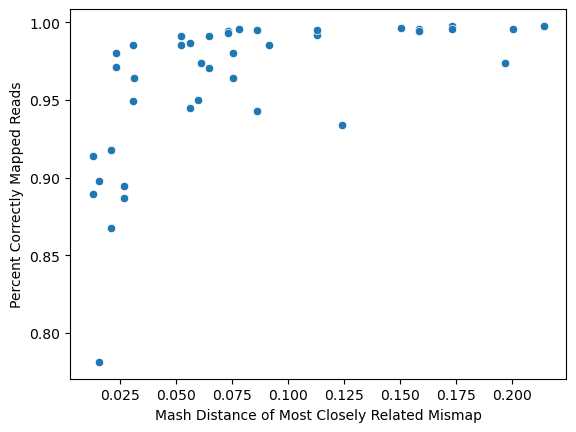

In [93]:
sns.scatterplot(x = closest, y = perc_correct)
plt.ylabel("Percent Correctly Mapped Reads")
plt.xlabel("Mash Distance of Most Closely Related Mismap")


✅ Best model: Weibull CDF
R² = 0.57687
Parameters: [0.99097066 0.00240406 0.43930711]


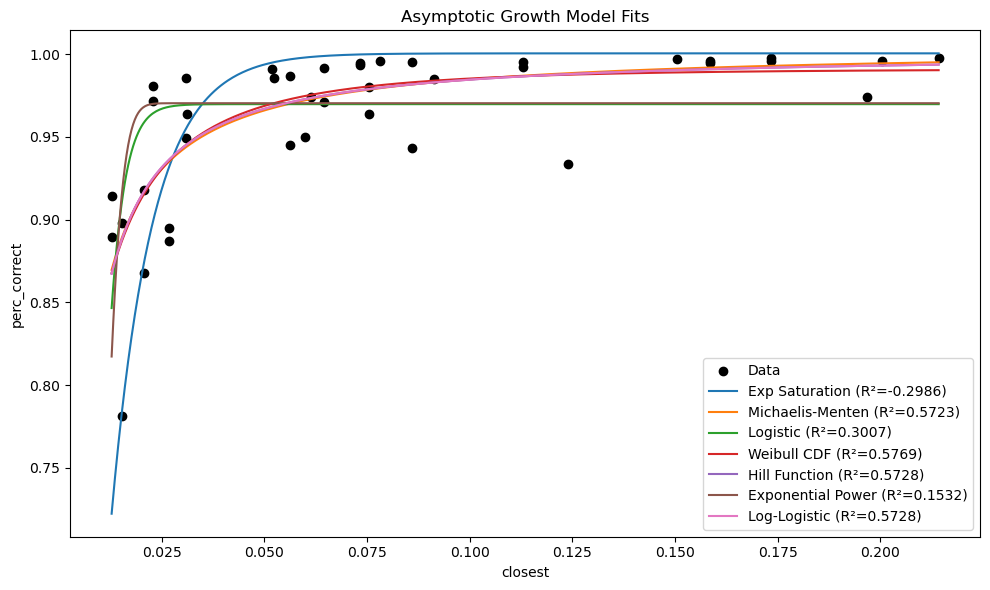

In [92]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# 1. Define all asymptotic models
# Models
def exp_saturation(x, a, b):
    return a * (1 - np.exp(-b * x))

def michaelis_menten(x, a, b):
    return (a * x) / (b + x)

def logistic(x, L, k, x0):
    base = 1 / (1 + np.exp(-k * (x - x0)))
    offset = 1 / (1 + np.exp(k * x0))  # value at x=0
    return L * (base - offset)

def weibull_cdf(x, a, b, c):
    return a * (1 - np.exp(- (x / b) ** c))

def hill_function(x, a, k, n):
    return a * (x**n) / (k**n + x**n)

def exp_power(x, a, b, c):
    return a * (1 - np.exp(-(b * x)**c))

def log_logistic(x, a, b, c):
    return a / (1 + (x / b) ** -c)


# Reasonable initial guesses and bounds
max_y = np.array(perc_correct).max()
x_median = np.median(np.array(closest))
models = {
    'Exp Saturation': (exp_saturation, [max_y, 10], (0, [1.1 * max_y, 100])),
    'Michaelis-Menten': (michaelis_menten, [max_y, x_median], (0, [1.1 * max_y, 1.0])),
    'Logistic': (logistic, [max_y, 100, x_median], (0, [1.1 * max_y, 1000, 1.0])),
    'Weibull CDF': (weibull_cdf, [max_y, x_median, 2.0], (0, [1.1 * max_y, 1.0, 10])),
    'Hill Function': (hill_function, [max_y, x_median, 2.0], (0, [1.1 * max_y, 1.0, 10])),
    'Exponential Power': (exp_power, [max_y, 10, 1.0], (0, [1.1 * max_y, 100, 10])),
    'Log-Logistic': (log_logistic, [max_y, x_median, 2.0], (0, [1.1 * max_y, 1.0, 10]))
}


# Fit models
fit_results = {}

for name, (func, p0, bounds) in models.items():
    try:
        popt, _ = curve_fit(func, closest, perc_correct, p0=p0, bounds=bounds, maxfev=10000)
        y_pred = func(closest, *popt)
        r2 = r2_score(perc_correct, y_pred)
        fit_results[name] = {'params': popt, 'r2': r2, 'func': func}
    except Exception as e:
        print(f"❌ {name} failed to fit: {e}")

# Best model
best_name, best_info = max(fit_results.items(), key=lambda kv: kv[1]['r2'])
print(f"\n✅ Best model: {best_name}")
print(f"R² = {best_info['r2']:.5f}")
print("Parameters:", best_info['params'])

# Plot
x_fit = np.linspace(min(closest), max(closest), 500)
plt.figure(figsize=(10, 6))
plt.scatter(closest, perc_correct, label='Data', color='black')

for name, info in fit_results.items():
    y_fit = info['func'](x_fit, *info['params'])
    plt.plot(x_fit, y_fit, label=f"{name} (R²={info['r2']:.4f})")

plt.xlabel("closest")
plt.ylabel("perc_correct")
plt.legend()
plt.title("Asymptotic Growth Model Fits")
plt.tight_layout()
plt.show()

In [19]:
test

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance,R1_Length,R1_Matches,R1_Insertions,...,R1_Softclips,R1_Hardclips,R1_AvgQual,R2_Length,R2_Matches,R2_Insertions,R2_Deletions,R2_Softclips,R2_Hardclips,R2_AvgQual
0,A_marinus_A00738:341:H7VHNDSX3:4:1101:1136:13604,146480,Ammodytes marinus,species,248,0.9899,same,99,1,0,...,0,0,36.27,149,2,0,0,0,0,36.01
1,A_marinus_A00738:341:H7VHNDSX3:4:1101:1244:24220,146480,Ammodytes marinus,species,298,1.0000,same,149,0,0,...,0,0,36.92,149,1,1,0,0,0,36.92
2,A_marinus_A00738:341:H7VHNDSX3:4:1101:1371:2300,146480,Ammodytes marinus,species,298,1.0000,same,149,0,0,...,0,0,36.68,149,2,0,0,0,0,36.01
3,A_marinus_A00738:341:H7VHNDSX3:4:1101:2058:9032,146480,Ammodytes marinus,species,295,1.0000,same,146,0,0,...,0,0,36.59,149,0,0,0,0,0,35.99
4,A_marinus_A00738:341:H7VHNDSX3:4:1101:3269:29543,146480,Ammodytes marinus,species,293,1.0000,same,144,3,0,...,0,0,36.92,149,0,0,0,0,0,36.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524469,Z_faber_E00526:585:HJLFCCCX2:6:2224:26961:60044,64108,Zeus faber,species,285,1.0000,same,137,0,0,...,0,0,39.96,148,2,0,0,0,0,39.52
1524470,Z_faber_E00526:585:HJLFCCCX2:6:2224:26961:71893,123368,Acanthomorphata,clade,272,0.9796,R2 less specific,87,1,3,...,0,0,40.21,98,2,0,0,0,0,39.07
1524471,Z_faber_E00526:585:HJLFCCCX2:6:2224:27245:25763,64108,Zeus faber,species,253,0.9583,same,120,5,0,...,0,0,40.02,133,4,0,5,0,0,39.42
1524472,Z_faber_E00526:585:HJLFCCCX2:6:2224:27935:29068,186625,Clupeocephala,no rank,204,1.0000,R2 less specific,36,0,0,...,0,46,40.44,107,2,0,0,26,0,38.69


In [231]:
import pandas as pd
from io import StringIO

# Load Mash distances
df = pd.read_csv("dists.tsv", sep="\t", header=None,
                 names=["species1", "species2", "distance", "shared", "pvalue"])

# Get unique species names
species = sorted(set(df["species1"]).union(set(df["species2"])))
species_clean = [s.replace(".fa.gz", "").replace("./reference_genomes/", "") for s in species]

# Initialize distance matrix
dist_matrix = pd.DataFrame(0.0, index=species_clean, columns=species_clean)

# Fill the matrix with Mash distances
for _, row in df.iterrows():
    s1 = row["species1"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    s2 = row["species2"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    dist_matrix.loc[s1, s2] = row["distance"]
    dist_matrix.loc[s2, s1] = row["distance"]

In [233]:
dist_matrix_subset = dist_matrix.reset_index(drop=False)

In [211]:
samplemap = keys.drop_duplicates("Run")
samplemap["sample"] = samplemap.Run

In [249]:
perc_correct = []
closest = []
for sp in set(keys["Constituent"][keys["Mix"] == "MixA"].tolist()):
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixA"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixA"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    print(sp, correctlymapped / totaltospecies, closestwrong)
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]

Thunnus_thynnus 0.9970762365659877 0.107087
Scomber_japonicus 0.7061702679483901 0.0154381
Salmo_salar 0.9567375975771092 0.0229895
Salvelinus_fontinalis 0.9944803457617926 0.0519596
Scomber_colias 0.6676759188958195 0.0154381
Salmo_trutta 0.9772238943420721 0.0229895
Scomber_scombrus 0.9819760464058617 0.052295


Text(0.5, 0, 'Mash Distance of Most Closely Related Mismap')

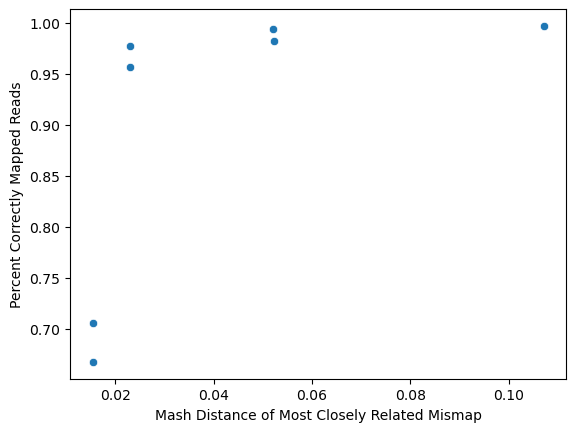

In [254]:
sns.scatterplot(x = closest, y = perc_correct)
plt.ylabel("Percent Correctly Mapped Reads")
plt.xlabel("Mash Distance of Most Closely Related Mismap")

In [188]:
((sum(test["TotalBases"][test["TaxName"] == "Salmo salar"]
 [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixA"][keys["Constituent"] == "Salmo_salar"].tolist()))])) / 
 (sum(test["TotalBases"][test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixA"][keys["Constituent"] == "Salmo_salar"].tolist()))])))

0.5670648632249295

In [169]:
rlens = test.copy()
rlens["len"] = rlens.groupby(["TaxName"])["TotalBases"].transform('sum')
rlens = rlens.drop_duplicates("TaxName").reset_index(drop=True)
rlens["len"] = rlens["len"]/ rlens["len"].sum()

In [228]:
dist_matrix["Scomber_scombrus"][dist_matrix["Scomber_scombrus"] != 0].sort_values().reset_index(drop=True)[0]

0.052295

In [149]:
genus_prefix = "Scomber_"
species_in_genus = [name for name in dist_matrix.index if name.startswith(genus_prefix)]

# Subset the matrix
subset_matrix = dist_matrix.loc[species_in_genus, species_in_genus]

In [150]:
subset_matrix 

,Scomber_colias,Scomber_japonicus,Scomber_scombrus
Scomber_colias,0.000000,0.015438,0.052374
Scomber_japonicus,0.015438,0.000000,0.052295
Scomber_scombrus,0.052374,0.052295,0.000000


In [151]:
import numpy as np

# To avoid division by zero, add a small epsilon
epsilon = 1e-6

# Invert distances: smaller distances get higher weights
weights_matrix = 1 / (subset_matrix + epsilon)

# Set diagonal (self-distances) to 0 — we don’t want to assign to self
np.fill_diagonal(weights_matrix.values, 0)

# Normalize each row to sum to 1
row_sums = weights_matrix.sum(axis=1)
normalized_weights = weights_matrix.div(row_sums, axis=0)


In [154]:
normalized_weights

,Scomber_colias,Scomber_japonicus,Scomber_scombrus
Scomber_colias,0.000000,0.772333,0.227667
Scomber_japonicus,0.772066,0.000000,0.227934
Scomber_scombrus,0.499621,0.500379,0.000000


In [145]:
import pandas as pd
from io import StringIO

# Load Mash distances
df = pd.read_csv("dists.tsv", sep="\t", header=None,
                 names=["species1", "species2", "distance", "shared", "pvalue"])

# Get unique species names
species = sorted(set(df["species1"]).union(set(df["species2"])))
species_clean = [s.replace(".fa.gz", "").replace("./reference_genomes/", "") for s in species]

# Initialize distance matrix
dist_matrix = pd.DataFrame(0.0, index=species_clean, columns=species_clean)

# Fill the matrix with Mash distances
for _, row in df.iterrows():
    s1 = row["species1"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    s2 = row["species2"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    dist_matrix.loc[s1, s2] = row["distance"]
    dist_matrix.loc[s2, s1] = row["distance"]

# Write PHYLIP format for neighbor-joining
with open("mash_distance.phy", "w") as f:
    f.write(f"{len(species_clean)}\n")
    for s in species_clean:
        padded = s[-10:].ljust(10)  # PHYLIP requires name ≤10 chars
        distances = " ".join(f"{dist_matrix.loc[s, t]:.5f}" for t in species_clean)
        f.write(f"{padded} {distances}\n")


In [144]:
dist_matrix

,Engraulis_ringens,Micromesistius_poutassou,Salmo_salar,Salmo_trutta,Salvelinus_fontinalis,Salvelinus_namaycush,Sardina_pilchardus,Scomber_colias,Scomber_japonicus,Scomber_scombrus,Thunnus_orientalis,Thunnus_thynnus
Engraulis_ringens,0.000000,0.203604,0.202933,0.210114,0.216771,0.210114,0.175137,0.210897,0.215016,0.216771,0.230110,0.230110
Micromesistius_poutassou,0.203604,0.000000,0.217673,0.226680,0.216771,0.218593,0.207842,0.221466,0.221466,0.220489,0.233808,0.226680
Salmo_salar,0.202933,0.217673,0.000000,0.022989,0.052355,0.048902,0.217673,0.222464,0.223483,0.216771,0.232543,0.236445
Salmo_trutta,0.210114,0.226680,0.022989,0.000000,0.051960,0.048688,0.220489,0.224525,0.224525,0.220489,0.226680,0.226680
Salvelinus_fontinalis,0.216771,0.216771,0.052355,0.051960,0.000000,0.018552,0.215016,0.222464,0.225590,0.216771,0.231311,0.230110
Salvelinus_namaycush,0.210114,0.218593,0.048902,0.048688,0.018552,0.000000,0.223483,0.217673,0.216771,0.214163,0.235108,0.231311
Sardina_pilchardus,0.175137,0.207842,0.217673,0.220489,0.215016,0.223483,0.000000,0.214163,0.221466,0.222464,0.224525,0.222464
Scomber_colias,0.210897,0.221466,0.222464,0.224525,0.222464,0.217673,0.214163,0.000000,0.015438,0.052374,0.108991,0.108070
Scomber_japonicus,0.215016,0.221466,0.223483,0.224525,0.225590,0.216771,0.221466,0.015438,0.000000,0.052295,0.107740,0.107087
Scomber_scombrus,0.216771,0.220489,0.216771,0.220489,0.216771,0.214163,0.222464,0.052374,0.052295,0.000000,0.109246,0.107331


In [170]:
rlens

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance,R1_Length,R1_Matches,R1_Insertions,...,R1_Hardclips,R1_AvgQual,R2_Length,R2_Matches,R2_Insertions,R2_Deletions,R2_Softclips,R2_Hardclips,R2_AvgQual,len
0,ERR12302715.1534,13677,Scomber scombrus,species,302,0.9669,same,151,6,2,...,0,34.67,151,5,5,0,0,0,36.59,0.107915
1,ERR12302715.12387,186745,Scombrinae,subfamily,181,1.0000,discordant,151,16,0,...,0,36.35,30,0,0,0,0,121,35.73,0.016302
2,ERR12302715.16863,13675,Scomber,genus,302,0.9934,discordant,151,1,0,...,0,36.18,151,0,0,0,38,0,27.42,0.210312
3,ERR12302715.96380,1489388,Euteleosteomorpha,cohort,442,0.9933,R1 less specific,150,1,0,...,0,34.61,146,4,0,0,90,0,22.63,0.021484
4,ERR12302715.234815,8237,Thunnus thynnus,species,149,0.7651,unpaired,149,21,1,...,0,36.66,0,0,0,0,0,0,0.00,0.120698
5,ERR12302715.369812,13676,Scomber japonicus,species,150,0.6800,unpaired,0,0,0,...,0,0.00,150,24,14,0,24,0,36.11,0.052173
6,ERR12302715.427869,8032,Salmo trutta,species,35,1.0000,unpaired,35,0,0,...,115,27.57,0,0,0,0,0,0,0.00,0.088938
7,ERR12302715.527957,8030,Salmo salar,species,151,0.9007,unpaired,151,15,11,...,0,36.75,0,0,0,0,0,0,0.00,0.088096
8,ERR12302715.843123,8038,Salvelinus fontinalis,species,151,0.7020,unpaired,0,0,0,...,0,0.00,151,1,0,0,44,0,27.12,0.105263
9,ERR12302715.937317,338315,Scomber colias,species,185,1.0000,same,149,3,0,...,0,36.68,36,0,0,0,0,111,36.33,0.058761


In [129]:
rlens

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance,len
0,ERR12302715.1534,13677,Scomber scombrus,species,302,0.9669,same,0.110173
1,ERR12302715.12387,13675,Scomber,genus,453,0.9603,R1 less specific,0.208427
2,ERR12302715.96380,1489388,Euteleosteomorpha,cohort,442,0.9933,R1 less specific,0.018715
3,ERR12302715.198510,186745,Scombrinae,subfamily,301,0.8742,discordant,0.012393
4,ERR12302715.234815,8237,Thunnus thynnus,species,149,0.7651,unpaired,0.121049
5,ERR12302715.369812,13676,Scomber japonicus,species,150,0.6800,unpaired,0.055353
6,ERR12302715.427869,8038,Salvelinus fontinalis,species,150,0.4867,unpaired,0.109224
7,ERR12302715.527957,8030,Salmo salar,species,151,0.9007,unpaired,0.090830
8,ERR12302715.533855,8032,Salmo trutta,species,299,0.7067,same,0.092682
9,ERR12302715.718442,338315,Scomber colias,species,302,0.8742,same,0.061688


In [120]:
test[test["TaxName"] == "Scomber japonicus"][~test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')][test["BestIdentity"] > 0.9]

/tmp/ipykernel_3425/4210623719.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test[test["TaxName"] == "Scomber japonicus"][~test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')][test["BestIdentity"] > 0.9]
/tmp/ipykernel_3425/4210623719.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test[test["TaxName"] == "Scomber japonicus"][~test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')][test["BestIdentity"] > 0.9]


,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance
696,ERR12302715.687754,13676,Scomber japonicus,species,301,0.9267,same
2954,ERR12302715.2943208,13676,Scomber japonicus,species,299,0.9133,same
3146,ERR12302715.3138248,13676,Scomber japonicus,species,237,0.9884,same
3828,ERR12302715.3844415,13676,Scomber japonicus,species,297,0.9467,same
5033,ERR12302715.5075028,13676,Scomber japonicus,species,150,0.9600,unpaired
...,...,...,...,...,...,...,...
803091,SRR33529942.12762531,13676,Scomber japonicus,species,296,0.9932,same
803115,SRR33529942.12770296,13676,Scomber japonicus,species,302,0.9536,same
803127,SRR33529942.12777049,13676,Scomber japonicus,species,302,1.0000,same
803129,SRR33529942.12777215,13676,Scomber japonicus,species,301,0.9669,same


In [103]:
test[test["TaxName"] == "Scomber japonicus"][~test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')]

/tmp/ipykernel_3425/2049393318.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test[test["TaxName"] == "Scomber japonicus"][~test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')]


,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance
153,ERR12302715.30961,13676,Scomber japonicus,species,150,0.7067,unpaired
422,ERR12302715.82208,13676,Scomber japonicus,species,150,0.7733,unpaired
446,ERR12302715.86157,13676,Scomber japonicus,species,300,0.2252,same
955,ERR12302715.190250,13676,Scomber japonicus,species,148,0.1689,unpaired
984,ERR12302715.195210,13676,Scomber japonicus,species,151,0.1987,unpaired
...,...,...,...,...,...,...,...
1199749,SRR33529942.12781445,13676,Scomber japonicus,species,238,0.9916,same
1199760,SRR33529942.12782084,13676,Scomber japonicus,species,299,0.9933,same
1199780,SRR33529942.12783858,13676,Scomber japonicus,species,298,1.0000,same
1199807,SRR33529942.12785502,13676,Scomber japonicus,species,232,0.9914,same


In [104]:
test

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance
0,ERR12302715.110,13677,Scomber scombrus,species,299,1.0000,same
1,ERR12302715.168,13677,Scomber scombrus,species,300,1.0000,same
2,ERR12302715.457,13677,Scomber scombrus,species,301,0.9801,same
3,ERR12302715.940,13677,Scomber scombrus,species,301,1.0000,same
4,ERR12302715.946,13677,Scomber scombrus,species,300,0.9934,same
...,...,...,...,...,...,...,...
1199813,SRR33529942.12785988,8032,Salmo trutta,species,149,0.8121,unpaired
1199814,SRR33529942.12786103,13675,Scomber,genus,450,0.9933,R1 less specific
1199815,SRR33529942.12786115,338315,Scomber colias,species,232,1.0000,same
1199816,SRR33529942.12786166,13675,Scomber,genus,299,0.9933,discordant


In [157]:
sum(test["TotalBases"][test["TaxName"] == "Scomber scombrus"][test["ReadName"].str.contains('ERR12302715|SRR11679558|SRR1766224')]) / sum(test["TotalBases"][test["TaxName"] == "Scomber scombrus"])

0.9816318094188717

In [158]:
sum(test["TotalBases"][test["TaxName"] == "Scomber japonicus"][test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')]) / sum(test["TotalBases"][test["TaxName"] == "Scomber japonicus"])

0.6990330824839185

In [123]:
test[test["ReadName"].str.contains('ERR12302715|SRR11679558|SRR1766224')].value_counts("TaxName")

TaxName
Scomber scombrus         101609
Scomber                   12197
Scombrinae                 1316
Euteleosteomorpha          1275
Scomber japonicus           560
Scomber colias              515
Thunnus thynnus             117
Salmo trutta                 76
Salmoninae                   64
Salmo salar                  44
Salvelinus fontinalis        41
Salmo                        21
Name: count, dtype: int64

In [127]:
test[test["ReadName"].str.contains('SRR16248221|SRR33529942|SRR25465274')].value_counts("TaxName")

TaxName
Scomber                  48211
Scomber colias           33900
Scomber japonicus        14076
Euteleosteomorpha         2152
Scomber scombrus          1219
Scombrinae                 947
Salmo salar                175
Thunnus thynnus            109
Salmo trutta                86
Salmoninae                  72
Salvelinus fontinalis       63
Salmo                       39
Name: count, dtype: int64

In [125]:
test[test["ReadName"].str.contains('SRR26673749|SRR12518676|SRR22396814')].value_counts("TaxName")

TaxName
Scomber                  51246
Scomber japonicus        32425
Scomber colias           17006
Euteleosteomorpha         1613
Scombrinae                 874
Scomber scombrus           718
Salmo salar                 92
Thunnus thynnus             76
Salmo trutta                74
Salvelinus fontinalis       55
Salmoninae                  50
Salmo                       30
Name: count, dtype: int64

In [126]:
sum(test["TotalBases"][test["TaxName"] == "Scomber colias"][test["ReadName"].str.contains('SRR33529942')]) / sum(test["TotalBases"][test["TaxName"] == "Scomber colias"])

0.21312861872945682

In [108]:
sum(test["TotalBases"][test["TaxName"] == "Salmo salar"][test["ReadName"].str.contains('SRR28213561')]) / sum(test["TotalBases"][test["TaxName"] == "Salmo salar"])

0.9573769473173506

In [113]:
sum(test["TotalBases"][test["TaxName"] == "Salmo trutta"][test["ReadName"].str.contains('ERR13511262')]) / sum(test["TotalBases"][test["TaxName"] == "Salmo trutta"])

0.9742833319608672

In [ ]:
sum(test["TotalBases"][test["TaxName"] == "Salmo salar"][~test["ReadName"].str.contains('SRR28213561')]) / sum(test["TotalBases"][test["TaxName"] == "Salmo salar"])

In [68]:
test[test["TaxName"] == "Salmo salar"][~test["ReadName"].str.contains('SRR28213561')].value_counts("TotalBases")

/tmp/ipykernel_3425/1606832345.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test[test["TaxName"] == "Salmo salar"][~test["ReadName"].str.contains('SRR28213561')].value_counts("TotalBases")


TotalBases
300    1055
299     912
298     509
297     259
151     241
       ... 
155       1
141       1
138       1
135       1
314       1
Name: count, Length: 199, dtype: int64

In [66]:
test[test["TaxName"] == "Salmo salar"][~test["ReadName"].str.contains('SRR28213561')].value_counts("ReadPairConcordance")

/tmp/ipykernel_3425/2935479695.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test[test["TaxName"] == "Salmo salar"][~test["ReadName"].str.contains('SRR28213561')].value_counts("ReadPairConcordance")


ReadPairConcordance
same        3928
unpaired     525
Name: count, dtype: int64

In [45]:
bases.sort_values("read_proportion")

,0,1,len,sum,read_proportion
21597,ERR12302715.4419020,27697:Sardina pilchardus:species,299,26056,0.000075
24364,ERR12302715.4996455,1489460:Clupeoidei:suborder,300,26139,0.000075
7677,ERR12302715.1558240,81636:Micromesistius poutassou:species,299,34814,0.000100
1599,ERR12302715.321289,217494:Engraulis ringens:species,102,50672,0.000146
17551,ERR12302715.3572708,8238:Thunnus orientalis:species,302,162602,0.000469
32072,ERR12302715.6587316,8237:Thunnus thynnus:species,302,208667,0.000602
51290,ERR12302715.10525347,8040:Salvelinus namaycush:species,302,387830,0.001119
16057,ERR12302715.3266156,8032:Salmo trutta:species,301,950093,0.002741
199,ERR12302715.39620,338315:Scomber colias:species,300,1136893,0.003280
446,ERR12302715.86157,13676:Scomber japonicus:species,300,1262696,0.003643


In [3]:
results = process_bam_streaming(bamfile = "MixD.merged.sorted.bam", 
                                acc2taxid_file = "acc2tid.gz", 
                                nodes_file = "nodes.dmp", 
                                names_file = "names.dmp", 
                                verbose=True)

🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 414,683 reference names in BAM
✅ Mapped 414683 reference IDs to taxids
📖 Opening BAM file: MixD.merged.sorted.bam
⏳ Processed 306,335 reads → 39,463 assigned
⏳ Processed 606,575 reads → 78,109 assigned
⏳ Processed 897,149 reads → 115,903 assigned
⏳ Processed 1,208,318 reads → 156,221 assigned
⏳ Processed 1,526,163 reads → 193,078 assigned
⏳ Processed 1,850,030 reads → 229,148 assigned
⏳ Processed 2,157,732 reads → 263,470 assigned
⏳ Processed 2,468,799 reads → 298,045 assigned
⏳ Processed 2,764,521 reads → 330,889 assigned
⏳ Processed 2,989,730 reads → 363,804 assigned
⏳ Processed 3,221,230 reads → 399,343 assigned
⏳ Processed 3,440,180 reads → 432,872 assigned
⏳ Processed 3,658,753 reads → 465,953 assigned
⏳ Processed 3,881,593 reads → 500,016 assigned
⏳ Processed 4,154,599 reads → 533,876 assigned
⏳ Processed 4,427,792 reads → 567,076 assigned
⏳ Processed 4,700,523 reads → 600,384 assigned
⏳ Processed 4,979,715 

In [82]:
results = process_bam_streaming(bamfile = "MixB.merged.sorted.bam", 
                                acc2taxid_file = "acc2tid", 
                                nodes_file = "nodes.dmp", 
                                names_file = "names.dmp", 
                                verbose=True)

🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 414,683 reference names in BAM
✅ Mapped 414683 reference IDs to taxids
📖 Opening BAM file: MixB.merged.sorted.bam
⏳ Processed 422,178 reads → 53,446 assigned
⏳ Processed 861,389 reads → 112,205 assigned
⏳ Processed 1,275,298 reads → 175,301 assigned
⏳ Processed 1,676,315 reads → 250,441 assigned
⏳ Processed 2,065,307 reads → 309,168 assigned
⏳ Processed 2,460,572 reads → 363,415 assigned
⏳ Processed 2,842,955 reads → 415,765 assigned
⏳ Processed 3,230,260 reads → 469,299 assigned
⏳ Processed 3,573,953 reads → 515,388 assigned
⏳ Processed 3,885,587 reads → 554,741 assigned
⏳ Processed 4,194,667 reads → 596,185 assigned
⏳ Processed 4,555,127 reads → 643,589 assigned
⏳ Processed 4,946,014 reads → 695,033 assigned
⏳ Processed 5,344,157 reads → 747,693 assigned
⏳ Processed 5,741,236 reads → 801,401 assigned
⏳ Processed 6,168,099 reads → 861,649 assigned
⏳ Processed 6,596,062 reads → 922,053 assigned
⏳ Processed 7,018,2

In [89]:
results = process_bam_streaming(bamfile = "MixA.merged.sorted.bam", 
                                acc2taxid_file = "acc2tid", 
                                nodes_file = "nodes.dmp", 
                                names_file = "names.dmp", 
                                verbose=True)

🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 414,683 reference names in BAM
✅ Mapped 414683 reference IDs to taxids
📖 Opening BAM file: MixA.merged.sorted.bam
⏳ Processed 400,113 reads → 50,867 assigned
⏳ Processed 824,707 reads → 100,341 assigned
⏳ Processed 1,226,596 reads → 152,084 assigned
⏳ Processed 1,661,052 reads → 213,631 assigned
⏳ Processed 2,098,119 reads → 268,911 assigned
⏳ Processed 2,491,957 reads → 328,737 assigned
⏳ Processed 2,903,913 reads → 404,007 assigned
⏳ Processed 3,322,546 reads → 465,251 assigned
⏳ Processed 3,674,673 reads → 512,935 assigned
⏳ Processed 4,093,410 reads → 569,106 assigned
⏳ Processed 4,505,964 reads → 623,810 assigned
⏳ Processed 4,935,191 reads → 675,184 assigned
⏳ Processed 5,364,045 reads → 728,262 assigned
⏳ Processed 5,801,631 reads → 784,264 assigned
✅ Done: 804,776 read pairs assigned in 43.3s


In [94]:
results = process_bam_streaming(bamfile = "MixC.merged.sorted.bam", 
                                acc2taxid_file = "acc2tid", 
                                nodes_file = "nodes.dmp", 
                                names_file = "names.dmp", 
                                verbose=True)

🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 414,683 reference names in BAM
✅ Mapped 414683 reference IDs to taxids
📖 Opening BAM file: MixC.merged.sorted.bam
⏳ Processed 423,017 reads → 53,510 assigned
⏳ Processed 835,505 reads → 101,608 assigned
⏳ Processed 1,243,062 reads → 154,689 assigned
⏳ Processed 1,607,435 reads → 206,919 assigned
⏳ Processed 2,027,675 reads → 265,522 assigned
⏳ Processed 2,426,097 reads → 320,373 assigned
⏳ Processed 2,734,292 reads → 359,359 assigned
⏳ Processed 3,053,974 reads → 402,970 assigned
⏳ Processed 3,423,213 reads → 450,497 assigned
⏳ Processed 3,841,924 reads → 508,910 assigned
⏳ Processed 4,271,785 reads → 569,588 assigned
⏳ Processed 4,697,152 reads → 629,449 assigned
⏳ Processed 5,120,144 reads → 687,390 assigned
⏳ Processed 5,528,717 reads → 737,408 assigned
⏳ Processed 5,957,481 reads → 790,367 assigned
⏳ Processed 6,375,708 reads → 842,134 assigned
⏳ Processed 6,783,690 reads → 892,393 assigned
⏳ Processed 7,178,9

In [41]:
results_df = pd.DataFrame(results)

In [42]:
tmp = results_df.copy()
tmp["sum"] = tmp.groupby([2])[4].transform('sum')
tmp = tmp.drop_duplicates(2).reset_index(drop=True)

In [43]:
tmp["prop"] = tmp["sum"] / tmp["sum"].sum()

In [44]:
tmp

,0,1,2,3,4,5,sum,prop
0,ERR12302715.110,13677,Scomber scombrus,species,299,1.0000,43465797,0.101736
1,ERR12302715.4871,13675,Scomber,genus,446,1.0000,81491013,0.190738
2,ERR12302715.7965,186745,Scombrinae,subfamily,1500,1.0000,4584720,0.010731
3,ERR12302715.30961,13676,Scomber japonicus,species,150,0.7067,29601974,0.069287
4,ERR12302715.37790,338315,Scomber colias,species,302,0.9073,17529767,0.041030
5,ERR12302715.41007,186625,Clupeocephala,no rank,300,0.6755,3501580,0.008196
6,ERR12302715.45277,1489388,Euteleosteomorpha,cohort,294,0.9799,6570720,0.015379
7,ERR12302715.80122,217494,Engraulis ringens,species,290,0.4681,33665,0.000079
8,ERR12302715.96207,8040,Salvelinus namaycush,species,299,0.8716,2775401,0.006496
9,ERR12302715.153696,123368,Acanthomorphata,clade,297,0.9470,317078,0.000742


In [122]:
tmp

,0,1,2,3,4,5,6,sum,prop
0,ERR12302715.110,13677,Scomber scombrus,species,299,1.0000,0,43538179,0.125962
1,ERR12302715.4871,13675,Scomber,genus,298,1.0000,3,30116772,0.087132
2,ERR12302715.7965,338315,Scomber colias,species,300,1.0000,0,40383524,0.116835
3,ERR12302715.9697,186745,Scombrinae,subfamily,302,0.9669,8,872211,0.002523
4,ERR12302715.30961,13676,Scomber japonicus,species,150,0.7067,4,29914881,0.086548
5,ERR12302715.41007,186625,Clupeocephala,no rank,300,0.6755,0,1230520,0.003560
6,ERR12302715.45277,1489388,Euteleosteomorpha,cohort,294,0.9799,4,3718546,0.010758
7,ERR12302715.80122,217494,Engraulis ringens,species,290,0.4681,0,97894,0.000283
8,ERR12302715.96207,8040,Salvelinus namaycush,species,299,0.8716,12,2836809,0.008207
9,ERR12302715.152619,504568,Salmoninae,subfamily,298,0.5436,1,5029764,0.014552


In [65]:
import pandas as pd
from collections import defaultdict, Counter
import math

def lineage(taxid, parent_map):
    path = []
    while taxid != 1 and taxid in parent_map:
        path.append(taxid)
        taxid = parent_map[taxid]
    path.append(1)
    return path

def find_lca(taxids, parent_map):
    sets = [set(lineage(tid, parent_map)) for tid in taxids]
    common = set.intersection(*sets)
    return max(common, key=lambda x: lineage(x, parent_map).index(x)) if common else 1

def stream_probabilistic_reassignment(assignments_iterator, parent_map, rank_map, max_preview=20):
    """
    Args:
        assignments_iterator: an iterator yielding tuples like:
            (read_name, taxid, tax_name, tax_rank, bases, percent_id, edit_dist)
        parent_map, rank_map: parsed from nodes.dmp
        max_preview: print this many reassigned reads as they are processed
    Yields:
        Reassigned entries: (read_name, original_taxid, reassigned_taxid, species_taxid, probability)
    """

    species_under_genus = defaultdict(set)
    identity_by_species = defaultdict(list)
    genus_reads = []

    print("📦 Building species identity model...")

    for row in assignments_iterator:
        read_name, taxid, tax_name, tax_rank, bases, pid, edit = row

        # Skip junk
        if taxid == 1 or pid is None or pd.isna(pid):
            continue

        tax_lineage = lineage(taxid, parent_map)
        tax_rank_here = rank_map.get(taxid, "no rank")

        if tax_rank_here == "species":
            # Map this species to its genus
            genus_taxid = next((t for t in tax_lineage if rank_map.get(t) == "genus"), None)
            if genus_taxid:
                species_under_genus[genus_taxid].add(taxid)
                identity_by_species[taxid].append(pid)

        elif tax_rank_here == "genus":
            genus_reads.append((read_name, taxid, tax_lineage, pid))

        # Optionally print previewed entries
        if len(identity_by_species) > 0 and len(genus_reads) >= max_preview:
            break

    print(f"✅ Built identity model with {len(identity_by_species)} species")

    # Now process genus-level reads and assign them probabilistically
    print(f"🔁 Reassigning {len(genus_reads)} genus-level reads...")

    count = 0
    for read_name, genus_taxid, lineage_path, pid in genus_reads:
        species_candidates = list(species_under_genus.get(genus_taxid, []))
        if not species_candidates:
            continue

        # Compute softmax-weighted probabilities based on identity distributions
        scores = []
        for staxid in species_candidates:
            identities = identity_by_species.get(staxid, [])
            if not identities:
                continue
            # Estimate mean identity and use it to weight this candidate
            mean_id = sum(identities) / len(identities)
            diff = abs(mean_id - pid)
            weight = math.exp(-diff * 10)  # tunable sharpness factor
            scores.append((staxid, weight))

        if not scores:
            continue

        total = sum(w for _, w in scores)
        scores = [(s, w / total) for s, w in scores]

        # Choose the species with max probability
        reassigned_taxid, prob = max(scores, key=lambda x: x[1])

        yield {
            "read_name": read_name,
            "original_taxid": genus_taxid,
            "reassigned_taxid": reassigned_taxid,
            "probability": round(prob, 3),
            "species_name": reassigned_taxid,  # You can use names_map here
        }

        count += 1
        if count >= max_preview:
            print(f"🔍 Previewed {count} reassigned reads")
            break


In [76]:
parent_map, rank_map = parse_nodes_dmp("nodes.dmp")  # your existing parser

# Stream the first 20 reassignments
reassigned_stream = stream_probabilistic_reassignment(iter(results), parent_map, rank_map, max_preview=200000)

for reassigned in reassigned_stream:
    print(reassigned)

In [62]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import gaussian_kde
from joblib import Parallel, delayed

def build_kde_for_taxid(taxid, values):
    if len(values) < 10:
        return taxid, None
    kde = gaussian_kde(values)
    return taxid, kde

def redistribute_taxa_fast(df, parent, rank, target_rank='species', verbose=True, n_jobs=4):
    """
    Redistribute reads assigned at higher taxonomic levels (e.g., genus)
    to child taxa (e.g., species) based on edit distance/identity.

    Parameters:
    - df: DataFrame with columns: read_name, taxid, tax_name, tax_rank, total_bases, best_identity, edit_distance
    - parent: dict mapping taxid → parent taxid (from nodes.dmp)
    - rank: dict mapping taxid → rank (from nodes.dmp)
    - target_rank: the rank you want to redistribute to (e.g., "species")
    - n_jobs: number of parallel jobs for KDE building

    Returns:
    - df with new column: `reassigned_taxid`
    """
    if verbose:
        print("🔍 Building KDE profiles for leaf taxa...")

    # Step 1: KDEs for leaf taxa
    species_df = df[df['tax_rank'] == target_rank]
    genus_df = df[df['tax_rank'] == 'genus']

    species_groups = species_df.groupby('taxid')['best_identity'].apply(list)
    kde_results = Parallel(n_jobs=n_jobs)(
        delayed(build_kde_for_taxid)(taxid, values)
        for taxid, values in species_groups.items()
    )
    identity_distributions = {taxid: kde for taxid, kde in kde_results if kde is not None}

    if verbose:
        print(f"✅ Built KDEs for {len(identity_distributions)} {target_rank}-level taxa")

    # Step 2: Genus → Species mapping
    genus_to_species = defaultdict(list)
    for tid, r in rank.items():
        if r == target_rank:
            lineage_tid = tid
            while lineage_tid in parent:
                parent_tid = parent[lineage_tid]
                if rank.get(parent_tid) == 'genus':
                    genus_to_species[parent_tid].append(tid)
                    break
                lineage_tid = parent_tid

    # Step 3: Reassign
    reassigned_taxids = []
    for idx, row in genus_df.iterrows():
        genus_id = row['taxid']
        identity = row['best_identity']
        candidates = genus_to_species.get(genus_id, [])
        scores = []

        for cand_id in candidates:
            kde = identity_distributions.get(cand_id)
            if kde:
                scores.append((cand_id, kde.evaluate([identity])[0]))

        if scores:
            total = sum(p for _, p in scores)
            assigned_taxid = max(scores, key=lambda x: x[1])[0] if total > 0 else genus_id
        else:
            assigned_taxid = genus_id

        reassigned_taxids.append((idx, assigned_taxid))

    # Step 4: Apply
    df['reassigned_taxid'] = df['taxid']
    for idx, new_tid in reassigned_taxids:
        df.at[idx, 'reassigned_taxid'] = new_tid

    return df


In [57]:
results.columns = ["read_name", "taxid", "tax_name", "tax_rank", 
                   "total_bases", "best_identity", "edit_distance"]

In [64]:
parent, rank = parse_nodes_dmp("nodes.dmp")

reassigned_df = redistribute_taxa_fast(results, parent, rank, target_rank="species")

🔍 Building KDE profiles for leaf taxa...
✅ Built KDEs for 12 species-level taxa


KeyboardInterrupt: 

In [ ]:
reassigned_df

In [47]:
results.sort_values(5)

,0,1,2,3,4,5,6
138037,ERR12302715.27917080,13676,Scomber japonicus,species,151,0.1656,0
444431,SRR5483576.177863413,27697,Sardina pilchardus,species,151,0.1656,0
788026,SRR28213561.34475276,8030,Salmo salar,species,302,0.1656,0
161344,ERR12302715.32688159,13676,Scomber japonicus,species,151,0.1656,0
654220,SRR26673749.116347027,81636,Micromesistius poutassou,species,151,0.1656,0
...,...,...,...,...,...,...,...
490862,SRR5483576.253029978,8237,Thunnus thynnus,species,274,1.0000,1
490863,SRR5483576.253037193,8238,Thunnus orientalis,species,302,1.0000,6
490865,SRR5483576.253042075,8238,Thunnus orientalis,species,282,1.0000,1
490843,SRR5483576.252983749,8234,Thunnus,genus,291,1.0000,5


In [32]:
results.head(60)

,0,1,2,3,4,5
0,ERR12302715.110,13677,Scomber scombrus,species,299,1.0000
1,ERR12302715.168,13677,Scomber scombrus,species,300,1.0000
2,ERR12302715.457,13677,Scomber scombrus,species,301,0.9801
3,ERR12302715.940,13677,Scomber scombrus,species,301,1.0000
4,ERR12302715.946,13677,Scomber scombrus,species,300,0.9934
5,ERR12302715.1325,13677,Scomber scombrus,species,302,1.0000
6,ERR12302715.1359,13677,Scomber scombrus,species,299,1.0000
7,ERR12302715.1363,13677,Scomber scombrus,species,302,1.0000
8,ERR12302715.1534,13677,Scomber scombrus,species,302,0.9669
9,ERR12302715.1815,13677,Scomber scombrus,species,302,1.0000


/tmp/ipykernel_139/3383110218.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[6][results[2] == "Scomber scombrus"])


<Axes: xlabel='6', ylabel='Density'>

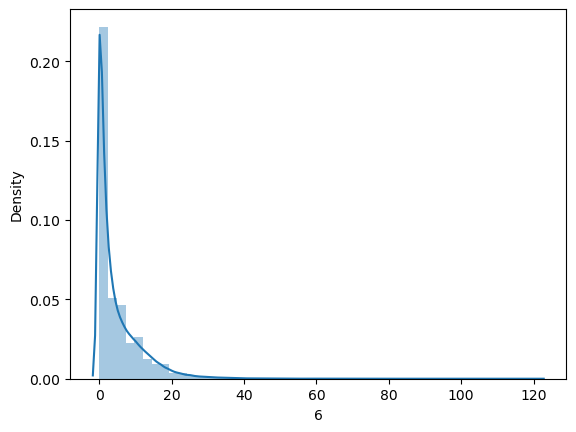

In [48]:
sns.distplot(results[6][results[2] == "Scomber scombrus"])

/tmp/ipykernel_139/2033542138.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[6][results[2] == "Scomber"])


<Axes: xlabel='6', ylabel='Density'>

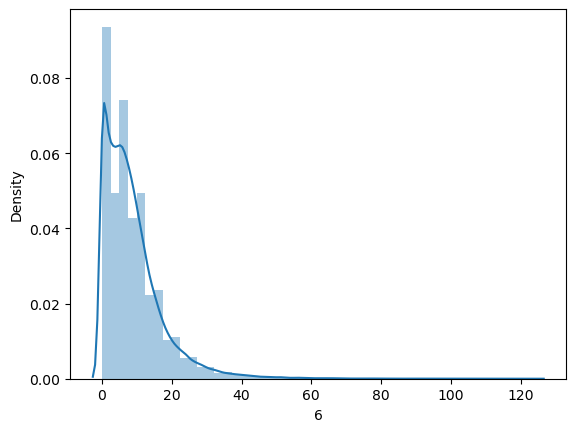

In [51]:
sns.distplot(results[6][results[2] == "Scomber"])

/tmp/ipykernel_139/3458796774.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[6][results[2] == "Scomber japonicus"])


<Axes: xlabel='6', ylabel='Density'>

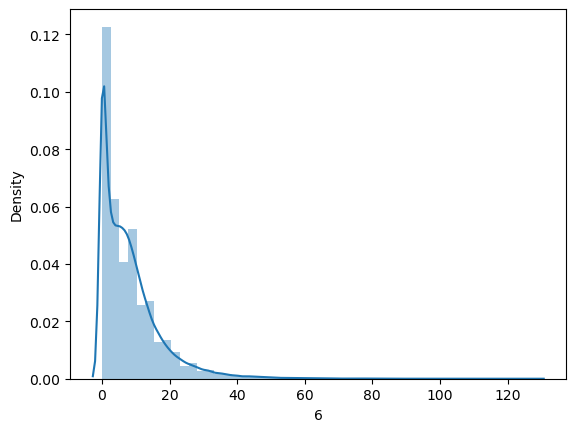

In [49]:
sns.distplot(results[6][results[2] == "Scomber japonicus"])

/tmp/ipykernel_139/193394158.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[6][results[2] == "Scomber colias"])


<Axes: xlabel='6', ylabel='Density'>

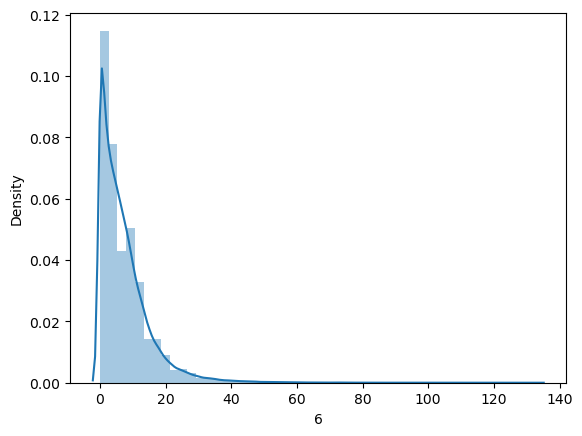

In [50]:
sns.distplot(results[6][results[2] == "Scomber colias"])

In [52]:
results[6][results[2] == "Scomber colias"].mean()

7.34960123871904

In [53]:
results[6][results[2] == "Scomber japonicus"].mean()

8.218849168419041

In [54]:
results[6][results[2] == "Scomber scombrus"].mean()

4.718403502450764

In [40]:
results[5][results[2] == "Scomber colias"].mean()

0.98324537909856

In [38]:
results[5][results[2] == "Scomber japonicus"].mean()

0.9823422251959474

In [39]:
results[5][results[2] == "Scomber scombrus"].mean()

0.9855994228298333

In [84]:
results_df = pd.DataFrame(results)

In [86]:
tmp = results_df.copy()
tmp["sum"] = tmp.groupby([2])[4].transform('sum')
tmp = tmp.drop_duplicates(2).reset_index(drop=True)

In [87]:
tmp["prop"] = tmp["sum"] / tmp["sum"].sum()

In [88]:
tmp

,0,1,2,3,4,5,6,sum,prop
0,ERR12302715.1534,13677,Scomber scombrus,species,302,0.9669,6,27635388,0.069550
1,ERR12302715.12387,338315,Scomber colias,species,302,0.9603,0,148772840,0.374417
2,ERR12302715.16863,13675,Scomber,genus,302,0.9934,0,69794225,0.175651
3,ERR12302715.96380,186625,Clupeocephala,no rank,296,0.9933,9,1298512,0.003268
4,ERR12302715.109577,1489388,Euteleosteomorpha,cohort,302,0.9934,8,5106841,0.012852
5,ERR12302715.198510,186745,Scombrinae,subfamily,301,0.8742,0,1249579,0.003145
6,ERR12302715.234815,8238,Thunnus orientalis,species,149,0.7718,21,18270097,0.045980
7,ERR12302715.267338,13676,Scomber japonicus,species,151,0.4503,0,65468077,0.164764
8,ERR12302715.404138,123368,Acanthomorphata,clade,295,1.0000,0,507096,0.001276
9,ERR12302715.427869,8038,Salvelinus fontinalis,species,150,0.4867,3,23453283,0.059025


In [11]:
ass = process_bam(bamfile = "MixD.merged.sorted.bam", 
                  acc2taxid_file = "acc2tid", nodes_file = "nodes.dmp", names_file = "names.dmp",
    verbose=True, max_reads=None)

🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 414,683 reference names in BAM
🔁 Linking BAM ref_id → accession → taxid
✅ Mapped 414683 reference IDs to taxids
📖 Opening BAM file: MixD.merged.sorted.bam


🧬 Collecting read pairs:   0%|▏                                                | 5087/1201216 [00:00<00:23, 50819.52reads/s]

⏳ Processed 0 alignments... 1 read pairs so far


🧬 Collecting read pairs:   1%|▌                                               | 14000/1201216 [00:00<00:39, 30296.25reads/s]

⏳ Processed 100,000 alignments... 12833 read pairs so far


🧬 Collecting read pairs:   2%|█                                               | 25989/1201216 [00:00<00:46, 25481.79reads/s]

⏳ Processed 200,000 alignments... 25787 read pairs so far


🧬 Collecting read pairs:   4%|█▋                                              | 42153/1201216 [00:01<00:44, 26235.26reads/s]

⏳ Processed 300,000 alignments... 38653 read pairs so far


🧬 Collecting read pairs:   5%|██▏                                             | 54851/1201216 [00:02<00:44, 25704.81reads/s]

⏳ Processed 400,000 alignments... 51549 read pairs so far


🧬 Collecting read pairs:   6%|██▊                                             | 70070/1201216 [00:02<00:48, 23144.03reads/s]

⏳ Processed 500,000 alignments... 64376 read pairs so far


🧬 Collecting read pairs:   7%|███▏                                            | 79275/1201216 [00:03<00:41, 27016.19reads/s]

⏳ Processed 600,000 alignments... 77265 read pairs so far


🧬 Collecting read pairs:   8%|███▊                                            | 94730/1201216 [00:03<00:40, 27126.72reads/s]

⏳ Processed 700,000 alignments... 90256 read pairs so far


🧬 Collecting read pairs:   9%|████                                           | 104293/1201216 [00:04<00:36, 30117.38reads/s]

⏳ Processed 800,000 alignments... 103216 read pairs so far


🧬 Collecting read pairs:  10%|████▋                                          | 120236/1201216 [00:04<00:40, 26816.37reads/s]

⏳ Processed 900,000 alignments... 116232 read pairs so far


🧬 Collecting read pairs:  11%|█████▏                                         | 133188/1201216 [00:05<00:35, 30500.04reads/s]

⏳ Processed 1,000,000 alignments... 129198 read pairs so far


🧬 Collecting read pairs:  12%|█████▊                                         | 148038/1201216 [00:05<00:41, 25219.81reads/s]

⏳ Processed 1,100,000 alignments... 142172 read pairs so far


🧬 Collecting read pairs:  13%|██████▎                                        | 160776/1201216 [00:06<00:34, 30023.32reads/s]

⏳ Processed 1,200,000 alignments... 155139 read pairs so far


🧬 Collecting read pairs:  14%|██████▋                                        | 170201/1201216 [00:06<00:34, 29810.33reads/s]

⏳ Processed 1,300,000 alignments... 167794 read pairs so far


🧬 Collecting read pairs:  15%|███████▏                                       | 184448/1201216 [00:07<00:43, 23158.87reads/s]

⏳ Processed 1,400,000 alignments... 178945 read pairs so far


🧬 Collecting read pairs:  16%|███████▌                                       | 193189/1201216 [00:07<00:37, 26775.15reads/s]

⏳ Processed 1,500,000 alignments... 190104 read pairs so far


🧬 Collecting read pairs:  17%|████████                                       | 204944/1201216 [00:08<00:35, 28172.19reads/s]

⏳ Processed 1,600,000 alignments... 201281 read pairs so far


🧬 Collecting read pairs:  18%|████████▏                                      | 210730/1201216 [00:08<00:34, 28537.32reads/s]

⏳ Processed 1,700,000 alignments... 212481 read pairs so far


🧬 Collecting read pairs:  19%|████████▉                                      | 227649/1201216 [00:09<00:41, 23407.19reads/s]

⏳ Processed 1,800,000 alignments... 223582 read pairs so far


🧬 Collecting read pairs:  20%|█████████▎                                     | 238707/1201216 [00:09<00:36, 26298.13reads/s]

⏳ Processed 1,900,000 alignments... 234715 read pairs so far


🧬 Collecting read pairs:  21%|█████████▊                                     | 250002/1201216 [00:10<00:35, 26718.61reads/s]

⏳ Processed 2,000,000 alignments... 245845 read pairs so far


🧬 Collecting read pairs:  22%|██████████▏                                    | 261091/1201216 [00:10<00:34, 27230.31reads/s]

⏳ Processed 2,100,000 alignments... 257027 read pairs so far


🧬 Collecting read pairs:  23%|██████████▋                                    | 272607/1201216 [00:11<00:48, 19278.96reads/s]

⏳ Processed 2,200,000 alignments... 268163 read pairs so far


🧬 Collecting read pairs:  24%|███████████                                    | 283966/1201216 [00:11<00:35, 25635.61reads/s]

⏳ Processed 2,300,000 alignments... 279299 read pairs so far


🧬 Collecting read pairs:  25%|███████████▌                                   | 295365/1201216 [00:12<00:32, 27712.84reads/s]

⏳ Processed 2,400,000 alignments... 290430 read pairs so far


🧬 Collecting read pairs:  26%|███████████▉                                   | 306442/1201216 [00:12<00:33, 26648.63reads/s]

⏳ Processed 2,500,000 alignments... 301489 read pairs so far


🧬 Collecting read pairs:  26%|████████████▍                                  | 317788/1201216 [00:13<00:31, 27963.29reads/s]

⏳ Processed 2,600,000 alignments... 312532 read pairs so far


🧬 Collecting read pairs:  27%|████████████▊                                  | 326527/1201216 [00:13<00:30, 28748.12reads/s]

⏳ Processed 2,700,000 alignments... 323678 read pairs so far


🧬 Collecting read pairs:  28%|█████████████▎                                 | 338797/1201216 [00:14<00:44, 19525.76reads/s]

⏳ Processed 2,800,000 alignments... 334824 read pairs so far


🧬 Collecting read pairs:  30%|█████████████▉                                 | 357724/1201216 [00:14<00:25, 32589.80reads/s]

⏳ Processed 2,900,000 alignments... 349925 read pairs so far


🧬 Collecting read pairs:  31%|██████████████▍                                | 369239/1201216 [00:15<00:22, 36191.03reads/s]

⏳ Processed 3,000,000 alignments... 365411 read pairs so far


🧬 Collecting read pairs:  32%|███████████████▏                               | 388304/1201216 [00:15<00:21, 37758.40reads/s]

⏳ Processed 3,100,000 alignments... 380719 read pairs so far


🧬 Collecting read pairs:  34%|███████████████▊                               | 403621/1201216 [00:16<00:20, 38031.70reads/s]

⏳ Processed 3,200,000 alignments... 396104 read pairs so far


🧬 Collecting read pairs:  35%|████████████████▍                              | 418914/1201216 [00:16<00:20, 38119.63reads/s]

⏳ Processed 3,300,000 alignments... 411413 read pairs so far


🧬 Collecting read pairs:  36%|████████████████▋                              | 426539/1201216 [00:16<00:20, 37808.41reads/s]

⏳ Processed 3,400,000 alignments... 426746 read pairs so far


🧬 Collecting read pairs:  37%|█████████████████▌                             | 447726/1201216 [00:17<00:26, 28377.11reads/s]

⏳ Processed 3,500,000 alignments... 441973 read pairs so far


🧬 Collecting read pairs:  39%|██████████████████▏                            | 465520/1201216 [00:18<00:18, 39234.47reads/s]

⏳ Processed 3,600,000 alignments... 457108 read pairs so far


🧬 Collecting read pairs:  40%|██████████████████▋                            | 478935/1201216 [00:18<00:16, 42586.05reads/s]

⏳ Processed 3,700,000 alignments... 472290 read pairs so far


🧬 Collecting read pairs:  41%|███████████████████▎                           | 492146/1201216 [00:18<00:16, 42449.02reads/s]

⏳ Processed 3,800,000 alignments... 487388 read pairs so far


🧬 Collecting read pairs:  42%|███████████████████▉                           | 509717/1201216 [00:19<00:16, 40905.77reads/s]

⏳ Processed 3,900,000 alignments... 502908 read pairs so far


🧬 Collecting read pairs:  43%|████████████████████▍                          | 521785/1201216 [00:19<00:18, 37707.16reads/s]

⏳ Processed 4,000,000 alignments... 515069 read pairs so far


🧬 Collecting read pairs:  46%|█████████████████████▋                         | 555681/1201216 [00:21<00:48, 13300.87reads/s]

⏳ Processed 4,300,000 alignments... 551543 read pairs so far


🧬 Collecting read pairs:  48%|██████████████████████▎                        | 570604/1201216 [00:21<00:24, 25995.37reads/s]

⏳ Processed 4,400,000 alignments... 563665 read pairs so far


🧬 Collecting read pairs:  48%|██████████████████████▊                        | 581661/1201216 [00:22<00:19, 32228.20reads/s]

⏳ Processed 4,500,000 alignments... 575969 read pairs so far


🧬 Collecting read pairs:  49%|███████████████████████▏                       | 592835/1201216 [00:22<00:17, 35413.03reads/s]

⏳ Processed 4,600,000 alignments... 588143 read pairs so far


🧬 Collecting read pairs:  51%|███████████████████████▊                       | 607612/1201216 [00:22<00:16, 36347.40reads/s]

⏳ Processed 4,700,000 alignments... 600320 read pairs so far


🧬 Collecting read pairs:  51%|████████████████████████▏                      | 618480/1201216 [00:23<00:16, 34837.25reads/s]

⏳ Processed 4,800,000 alignments... 612411 read pairs so far


🧬 Collecting read pairs:  54%|█████████████████████████▏                     | 643597/1201216 [00:23<00:15, 35713.73reads/s]

⏳ Processed 5,000,000 alignments... 636666 read pairs so far


🧬 Collecting read pairs:  54%|█████████████████████████▌                     | 654235/1201216 [00:24<00:15, 35092.80reads/s]

⏳ Processed 5,100,000 alignments... 648757 read pairs so far


🧬 Collecting read pairs:  56%|██████████████████████████                     | 667187/1201216 [00:24<00:17, 30219.72reads/s]

⏳ Processed 5,200,000 alignments... 660922 read pairs so far


🧬 Collecting read pairs:  56%|██████████████████████████▍                    | 676245/1201216 [00:25<00:18, 28564.81reads/s]

⏳ Processed 5,300,000 alignments... 672747 read pairs so far


🧬 Collecting read pairs:  57%|███████████████████████████▍                    | 687908/1201216 [00:26<01:00, 8499.11reads/s]

⏳ Processed 5,400,000 alignments... 684042 read pairs so far


🧬 Collecting read pairs:  58%|███████████████████████████▎                   | 697872/1201216 [00:27<00:29, 17129.98reads/s]

⏳ Processed 5,500,000 alignments... 695215 read pairs so far


🧬 Collecting read pairs:  59%|███████████████████████████▊                   | 711263/1201216 [00:27<00:18, 27011.79reads/s]

⏳ Processed 5,600,000 alignments... 706506 read pairs so far


🧬 Collecting read pairs:  60%|████████████████████████████▏                  | 721468/1201216 [00:27<00:15, 30659.96reads/s]

⏳ Processed 5,700,000 alignments... 717741 read pairs so far


🧬 Collecting read pairs:  61%|████████████████████████████▍                  | 727681/1201216 [00:28<00:19, 24337.87reads/s]

⏳ Processed 5,800,000 alignments... 728939 read pairs so far


🧬 Collecting read pairs:  62%|████████████████████████████▉                  | 740905/1201216 [00:29<00:32, 14104.41reads/s]

⏳ Processed 5,900,000 alignments... 740049 read pairs so far


🧬 Collecting read pairs:  63%|█████████████████████████████▍                 | 753699/1201216 [00:29<00:24, 17922.54reads/s]

⏳ Processed 6,000,000 alignments... 751162 read pairs so far


🧬 Collecting read pairs:  64%|██████████████████████████████                 | 768558/1201216 [00:30<00:17, 24837.72reads/s]

⏳ Processed 6,100,000 alignments... 762414 read pairs so far


🧬 Collecting read pairs:  65%|██████████████████████████████▍                | 777537/1201216 [00:30<00:16, 25308.41reads/s]

⏳ Processed 6,200,000 alignments... 773587 read pairs so far


🧬 Collecting read pairs:  66%|██████████████████████████████▊                | 787377/1201216 [00:31<00:19, 20850.34reads/s]

⏳ Processed 6,300,000 alignments... 784836 read pairs so far


🧬 Collecting read pairs:  66%|███████████████████████████████▏               | 797739/1201216 [00:31<00:18, 21703.86reads/s]

⏳ Processed 6,400,000 alignments... 795999 read pairs so far


🧬 Collecting read pairs:  67%|███████████████████████████████▋               | 810795/1201216 [00:32<00:15, 25360.30reads/s]

⏳ Processed 6,500,000 alignments... 807128 read pairs so far


🧬 Collecting read pairs:  68%|████████████████████████████████▏              | 821829/1201216 [00:32<00:14, 26866.54reads/s]

⏳ Processed 6,600,000 alignments... 818240 read pairs so far


🧬 Collecting read pairs:  69%|████████████████████████████████▌              | 833009/1201216 [00:33<00:14, 26119.87reads/s]

⏳ Processed 6,700,000 alignments... 829418 read pairs so far


🧬 Collecting read pairs:  70%|█████████████████████████████████▋              | 844484/1201216 [00:34<00:47, 7492.59reads/s]

⏳ Processed 6,800,000 alignments... 840659 read pairs so far


🧬 Collecting read pairs:  71%|█████████████████████████████████▍             | 854405/1201216 [00:35<00:23, 14939.01reads/s]

⏳ Processed 6,900,000 alignments... 852422 read pairs so far


🧬 Collecting read pairs:  72%|██████████████████████████████████             | 869367/1201216 [00:36<00:21, 15191.43reads/s]

⏳ Processed 7,000,000 alignments... 864203 read pairs so far


🧬 Collecting read pairs:  73%|██████████████████████████████████▎            | 876234/1201216 [00:36<00:14, 22059.85reads/s]

⏳ Processed 7,100,000 alignments... 875932 read pairs so far


🧬 Collecting read pairs:  74%|██████████████████████████████████▉            | 892394/1201216 [00:37<00:13, 22680.39reads/s]

⏳ Processed 7,200,000 alignments... 887783 read pairs so far


🧬 Collecting read pairs:  75%|███████████████████████████████████▍           | 905645/1201216 [00:38<00:10, 28279.90reads/s]

⏳ Processed 7,300,000 alignments... 899591 read pairs so far


🧬 Collecting read pairs:  76%|███████████████████████████████████▊           | 914904/1201216 [00:38<00:09, 29126.82reads/s]

⏳ Processed 7,400,000 alignments... 911368 read pairs so far


🧬 Collecting read pairs:  77%|████████████████████████████████████▎          | 927550/1201216 [00:39<00:13, 20027.36reads/s]

⏳ Processed 7,500,000 alignments... 923205 read pairs so far


🧬 Collecting read pairs:  78%|████████████████████████████████████▋          | 938866/1201216 [00:39<00:11, 23481.62reads/s]

⏳ Processed 7,600,000 alignments... 935000 read pairs so far


🧬 Collecting read pairs:  79%|█████████████████████████████████████▏         | 950680/1201216 [00:40<00:12, 19711.67reads/s]

⏳ Processed 7,700,000 alignments... 946723 read pairs so far


🧬 Collecting read pairs:  80%|█████████████████████████████████████▌         | 959452/1201216 [00:40<00:13, 17897.33reads/s]

⏳ Processed 7,800,000 alignments... 958537 read pairs so far


🧬 Collecting read pairs:  81%|██████████████████████████████████████▏        | 975264/1201216 [00:41<00:09, 25049.21reads/s]

⏳ Processed 7,900,000 alignments... 970248 read pairs so far


🧬 Collecting read pairs:  82%|██████████████████████████████████████▌        | 984577/1201216 [00:41<00:08, 25574.81reads/s]

⏳ Processed 8,000,000 alignments... 981974 read pairs so far


🧬 Collecting read pairs:  84%|███████████████████████████████████████▍       | 1006667/1201216 [00:45<00:30, 6379.06reads/s]

⏳ Processed 8,200,000 alignments... 1005503 read pairs so far


🧬 Collecting read pairs:  85%|███████████████████████████████████████▏      | 1023790/1201216 [00:46<00:08, 20609.28reads/s]

⏳ Processed 8,300,000 alignments... 1017694 read pairs so far


🧬 Collecting read pairs:  86%|███████████████████████████████████████▋      | 1035509/1201216 [00:46<00:07, 22485.83reads/s]

⏳ Processed 8,400,000 alignments... 1030432 read pairs so far


🧬 Collecting read pairs:  87%|████████████████████████████████████████▏     | 1047977/1201216 [00:47<00:06, 24197.04reads/s]

⏳ Processed 8,500,000 alignments... 1043195 read pairs so far


🧬 Collecting read pairs:  88%|█████████████████████████████████████████▌     | 1061743/1201216 [00:50<00:15, 9138.83reads/s]

⏳ Processed 8,600,000 alignments... 1056069 read pairs so far


🧬 Collecting read pairs:  89%|█████████████████████████████████████████▉     | 1071319/1201216 [00:54<00:30, 4211.70reads/s]

⏳ Processed 8,700,000 alignments... 1069007 read pairs so far


🧬 Collecting read pairs:  92%|██████████████████████████████████████████▏   | 1103131/1201216 [00:55<00:03, 25824.68reads/s]

⏳ Processed 8,900,000 alignments... 1095361 read pairs so far


🧬 Collecting read pairs:  93%|██████████████████████████████████████████▋   | 1113821/1201216 [00:56<00:02, 30162.00reads/s]

⏳ Processed 9,000,000 alignments... 1108558 read pairs so far


🧬 Collecting read pairs:  94%|████████████████████████████████████████████▍  | 1134973/1201216 [00:59<00:11, 5616.64reads/s]

⏳ Processed 9,200,000 alignments... 1134207 read pairs so far


🧬 Collecting read pairs:  97%|████████████████████████████████████████████▌ | 1163572/1201216 [01:00<00:01, 20978.45reads/s]

⏳ Processed 9,400,000 alignments... 1159898 read pairs so far


🧬 Collecting read pairs:  98%|█████████████████████████████████████████████ | 1175995/1201216 [01:01<00:01, 22918.08reads/s]

⏳ Processed 9,500,000 alignments... 1173004 read pairs so far


🧬 Collecting read pairs:  99%|█████████████████████████████████████████████▌| 1189890/1201216 [01:01<00:00, 23190.87reads/s]

⏳ Processed 9,600,000 alignments... 1186183 read pairs so far


🧬 Collecting read pairs: 100%|██████████████████████████████████████████████| 1201216/1201216 [01:02<00:00, 19254.30reads/s]


⏳ Processed 9,700,000 alignments... 1199333 read pairs so far
✅ Collected 1201216 read pairs from 9,321,052 primary alignments in 90.81 sec
🏁 Finished assigning taxonomy to 1201216 read pairs


In [12]:
ass

[('ERR12302715.110', 13677, 'Scomber scombrus', 'species', 299),
 ('ERR12302715.168', 13677, 'Scomber scombrus', 'species', 300),
 ('ERR12302715.457', 13677, 'Scomber scombrus', 'species', 301),
 ('ERR12302715.940', 13677, 'Scomber scombrus', 'species', 301),
 ('ERR12302715.946', 13677, 'Scomber scombrus', 'species', 300),
 ('ERR12302715.1325', 13677, 'Scomber scombrus', 'species', 302),
 ('ERR12302715.1359', 13677, 'Scomber scombrus', 'species', 299),
 ('ERR12302715.1363', 13677, 'Scomber scombrus', 'species', 302),
 ('ERR12302715.1534', 13677, 'Scomber scombrus', 'species', 302),
 ('ERR12302715.1815', 13677, 'Scomber scombrus', 'species', 302),
 ('ERR12302715.2310', 13677, 'Scomber scombrus', 'species', 300),
 ('ERR12302715.2959', 13677, 'Scomber scombrus', 'species', 301),
 ('ERR12302715.3100', 13677, 'Scomber scombrus', 'species', 298),
 ('ERR12302715.4199', 13677, 'Scomber scombrus', 'species', 301),
 ('ERR12302715.4414', 13677, 'Scomber scombrus', 'species', 302),
 ('ERR12302715.

In [47]:
import pysam
from collections import defaultdict

# Load taxonomy tree from NCBI dump (taxid -> parent)
def load_taxonomy_nodes(filename):
    parent = {}
    with open(filename) as f:
        for line in f:
            toks = line.strip().split("|")
            taxid = int(toks[0].strip())
            par = int(toks[1].strip())
            parent[taxid] = par
    return parent

# Load rank and name mappings
def load_taxonomy_names(filename):
    rank = {}
    name = {}
    with open(filename) as f:
        for line in f:
            toks = line.strip().split("|")
            taxid = int(toks[0].strip())
            taxname = toks[1].strip()
            classname = toks[3].strip()
            if classname == "scientific name":
                name[taxid] = taxname
            # assuming you can pull rank from nodes.dmp later
    return name

# Find LCA
def get_lca(t1, t2, parent):
    lineage1 = set()
    while t1 != parent.get(t1, t1):
        lineage1.add(t1)
        t1 = parent[t1]
    lineage1.add(t1)

    while t2 != parent.get(t2, t2):
        if t2 in lineage1:
            return t2
        t2 = parent[t2]
    if t2 in lineage1:
        return t2
    return 1  # root

# Compute specificity based on depth from root
def depth(taxid, parent):
    d = 0
    while taxid != parent.get(taxid, taxid):
        taxid = parent[taxid]
        d += 1
    return d

# Main LCA function
def assign_fragment_taxa(bamfile, taxid_map, parent_map, name_map):
    best_alignments = defaultdict(lambda: {1: None, 2: None})

    with pysam.AlignmentFile(bamfile, "rb") as bam:
        for aln in bam.fetch(until_eof=True):
            if aln.is_unmapped:
                continue

            read_name = aln.query_name
            is_read1 = aln.is_read1
            mate = 1 if is_read1 else 2

            try:
                edit = aln.get_tag("NM")
            except KeyError:
                continue
            read_len = aln.query_length
            score = edit / read_len

            refid = aln.reference_id
            refname = bam.get_reference_name(refid)
            if refname not in taxid_map:
                continue
            taxid = taxid_map[refname]

            prev = best_alignments[read_name][mate]
            if prev is None or score < prev["score"]:
                best_alignments[read_name][mate] = {
                    "taxid": taxid,
                    "score": score
                }

    # Resolve fragment-level assignments
    for read, ends in best_alignments.items():
        r1, r2 = ends[1], ends[2]
        if r1 and r2:
            if r1["taxid"] == r2["taxid"]:
                final = r1["taxid"]
            else:
                d1 = depth(r1["taxid"], parent_map)
                d2 = depth(r2["taxid"], parent_map)
                if d1 > d2:
                    final = r1["taxid"]
                elif d2 > d1:
                    final = r2["taxid"]
                else:
                    final = get_lca(r1["taxid"], r2["taxid"], parent_map)
        elif r1:
            final = r1["taxid"]
        elif r2:
            final = r2["taxid"]
        else:
            continue

        taxname = name_map.get(final, "Unknown")
        print(f"{read}\t{final}\t{taxname}")

In [8]:
reads = pd.read_csv("./summary_file_bowtie.txt", sep = "\t")
reads["minMAPQ0"] = reads["minMAPQ0"] / reads["All Reads"]
reads["minMAPQ20"] = reads["minMAPQ20"] / reads["All Reads"]
reads["minMAPQ42"] = reads["minMAPQ42"] / reads["All Reads"]
reads1 = pd.read_csv("./summary_file.txt", sep = "\t")
reads1["minMAPQ0"] = reads1["minMAPQ0"] / reads1["All Reads"]
reads1["minMAPQ20"] = reads1["minMAPQ20"] / reads1["All Reads"]
reads1["minMAPQ60"] = reads1["minMAPQ60"] / reads1["All Reads"]

In [77]:
genomesizes = {"Salmo_salar": 2756563003, 
               "Engraulis_ringens": 1380003550,
               "Sardina_pilchardus": 869065667, 
               "Micromesistius_poutassou": 520025573, 
               "Scomber_scombrus": 763843472}

In [78]:
reads = reads[~reads["Sample"].str.contains("best")].reset_index(drop=True)
reads1 = reads1[~reads1["Sample"].str.contains("best")].reset_index(drop=True)

In [79]:
reads["Feed"] = reads["Sample"].str.split("_", expand = True)[0]
reads["Species"] = reads["Sample"].str.split("_", expand = True, n = 1)[1]
reads1["Feed"] = reads1["Sample"].str.split("_", expand = True)[0]
reads1["Species"] = reads1["Sample"].str.split("_", expand = True, n = 1)[1]

In [19]:
reads[reads["Sample"] == "AF005_Engraulis_ringens"]

,minMAPQ0,minMAPQ20,minMAPQ42,All Reads,Sample
2,0.087939,0.002424,0.000259,504779811,AF005_Engraulis_ringens


In [39]:
reads.coverage = np.nan
for species in list(genomesizes.keys()):
    reads.loc[reads["Species"] == species, "coverage"] = (reads["minMAPQ42"] * reads["All Reads"] ) / genomesizes[species]

In [80]:
df = pd.DataFrame()
for thresh in ["42", "20", "0"]:
    test = pd.DataFrame(data = reads["minMAPQ" + thresh].tolist(), columns = ["x"])
    test["g"] = "minMAPQ" + thresh + "_bowtie"
    df = pd.concat([df, test])
for thresh in ["60", "20", "0"]:
    test = pd.DataFrame(data = reads1["minMAPQ" + thresh].tolist(), columns = ["x"])
    test["g"] = "minMAPQ" + thresh + "_bwa"
    df = pd.concat([df, test])

<Axes: xlabel='minMAPQ0', ylabel='Density'>

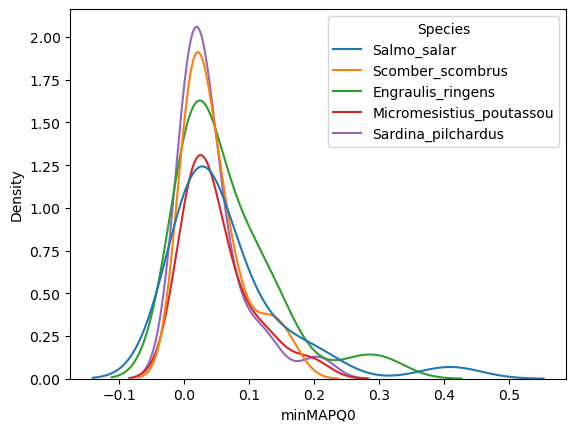

In [42]:
sns.kdeplot(data = reads, x = "minMAPQ0", hue = "Species")

<Axes: xlabel='minMAPQ20', ylabel='Density'>

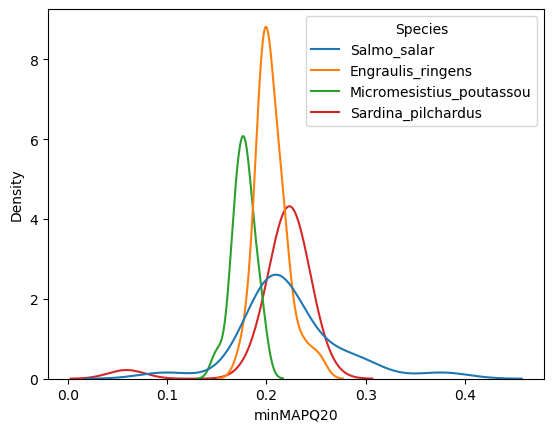

In [60]:
sns.kdeplot(data = reads, x = "minMAPQ20", hue = "Species")

<Axes: xlabel='minMAPQ60', ylabel='Density'>

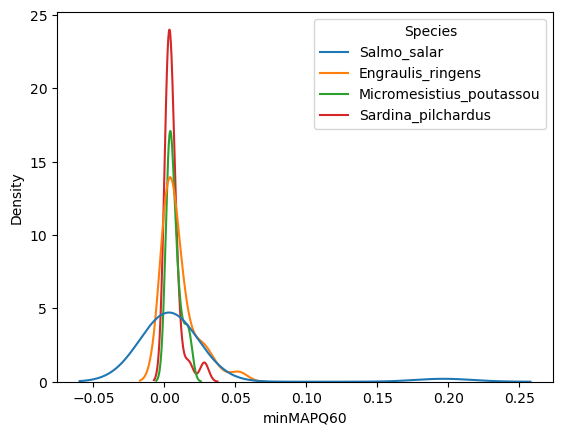

In [61]:
sns.kdeplot(data = reads, x = "minMAPQ60", hue = "Species")

In [10]:
reads

,minMAPQ0,minMAPQ20,minMAPQ42,All Reads,Sample
0,0.041012,0.001959,0.000220,503092025,AF002_Salmo_salar
1,0.017358,0.000154,0.000003,503092025,AF002_Scomber_scombrus
2,0.087939,0.002424,0.000259,504779811,AF005_Engraulis_ringens
3,0.129761,0.001576,0.000052,504779811,AF005_Salmo_salar
4,0.133922,0.001319,0.000033,504779811,AF005_Scomber_scombrus
...,...,...,...,...,...
148,0.016429,0.000166,0.000002,683199417,AF210_Salmo_salar
149,0.017663,0.000281,0.000052,683199417,AF210_Scomber_scombrus
150,0.044775,0.001229,0.000151,631862833,AF213_Engraulis_ringens
151,0.060649,0.000782,0.000017,631862833,AF213_Scomber_scombrus


/tmp/ipykernel_1617/3791320025.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((reads1["minMAPQ60"]), label = "MAPQ=60")
/tmp/ipykernel_1617/3791320025.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((reads1["minMAPQ20"]), label = "MAPQ>=20")
/tmp/ipykernel_1617/3791320025.py:3: UserWarn

Text(0.5, 0, 'Proportion of Bases Mapped')

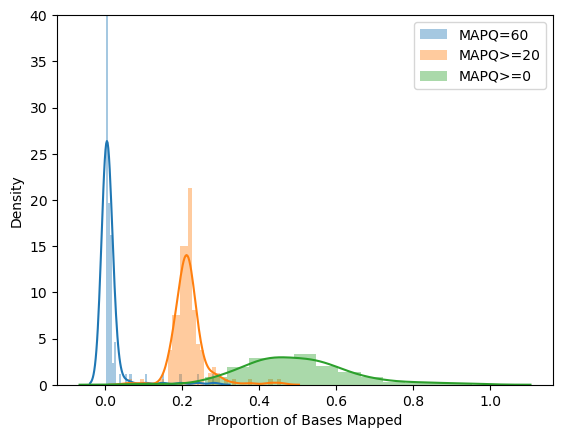

In [14]:
sns.distplot((reads1["minMAPQ60"]), label = "MAPQ=60")
sns.distplot((reads1["minMAPQ20"]), label = "MAPQ>=20")
sns.distplot((reads1["minMAPQ0"]), label = "MAPQ>=0")
plt.ylim(0,40)
plt.legend()
plt.xlabel("Proportion of Bases Mapped")

/tmp/ipykernel_1617/2165531406.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((reads["minMAPQ42"]), label = "MAPQ=42")
/tmp/ipykernel_1617/2165531406.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((reads["minMAPQ20"]), label = "MAPQ>=20")
/tmp/ipykernel_1617/2165531406.py:3: UserWarnin

Text(0.5, 0, 'Proportion of Bases Mapped')

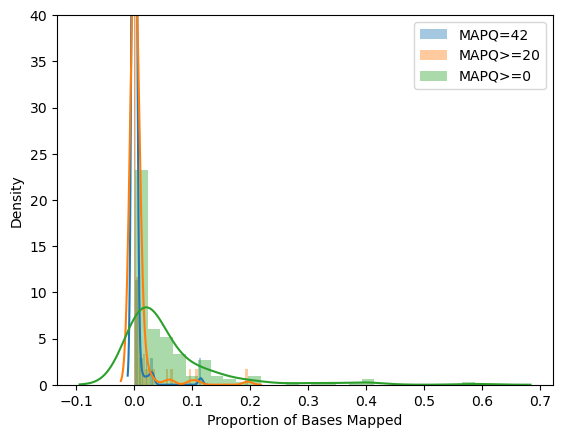

In [15]:
sns.distplot((reads["minMAPQ42"]), label = "MAPQ=42")
sns.distplot((reads["minMAPQ20"]), label = "MAPQ>=20")
sns.distplot((reads["minMAPQ0"]), label = "MAPQ>=0")
plt.ylim(0,40)
plt.legend()
plt.xlabel("Proportion of Bases Mapped")

In [3]:
metadata = pd.read_csv("./aquafeed_metadata.csv")

In [6]:
distinct_palette = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # olive
    "#17becf",  # cyan
    "#393b79",  # dark blue
    "#637939",  # dark green
    "#843c39",  # dark red
    "#6b6ecf",  # soft violet
]

In [16]:
bamlist = pd.read_csv("./Salmo_salar.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_192/4114144141.py:12: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


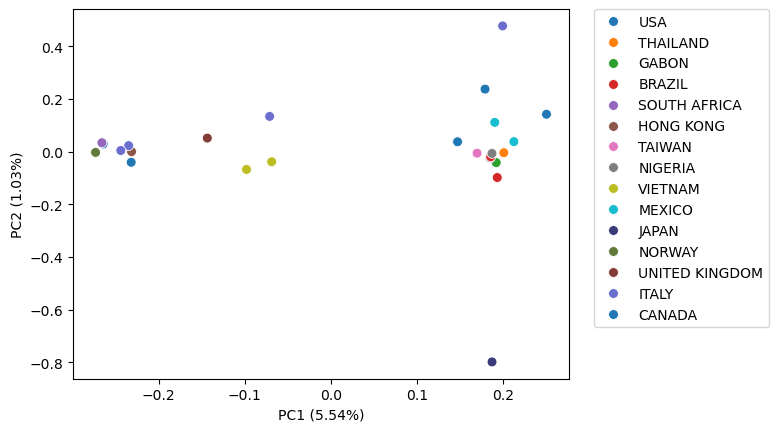

In [17]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Salmo_salar.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [18]:
bamlist = pd.read_csv("./Sardina_pilchardus.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_192/443480705.py:12: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


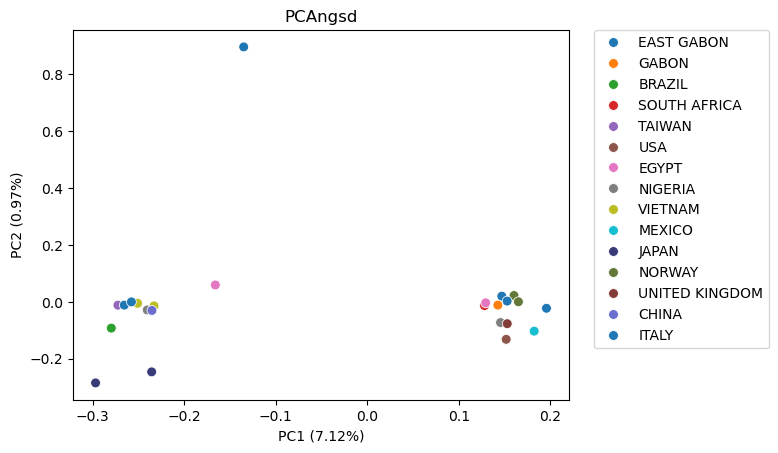

In [19]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Sardina_pilchardus.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [20]:
bamlist[bamlist["PC2"] > 0.8]

,sample_id,sample_type,field_id,feed_pellet,intended_for,country,locality,manufacturer_country,manufacturer,formulation,...,manufacture_date,date_of_receipt,misc,notes,common_name,species,family,intended_for_latin,PC1,PC2
22,AF203,experimental,NaN,y,Mediterranean trout|Marble trout\n,ITALY,NaN,ITALY,Skretting,Nutra 3.0,...,20191203,20200114.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.135066,0.896172


In [21]:
bamlist = pd.read_csv("./Micromesistius_poutassou.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_192/3697993267.py:12: UserWarning: The palette list has more values (14) than needed (11), which may not be intended.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


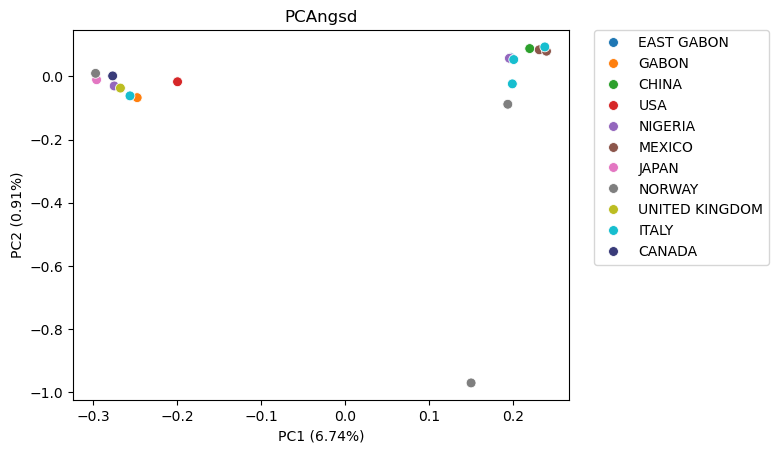

In [22]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Micromesistius_poutassou.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [23]:
bamlist[bamlist["PC2"] < 0][bamlist["PC1"] > 0.1]

/tmp/ipykernel_192/625346405.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bamlist[bamlist["PC2"] < 0][bamlist["PC1"] > 0.1]


,sample_id,sample_type,field_id,feed_pellet,intended_for,country,locality,manufacturer_country,manufacturer,formulation,...,manufacture_date,date_of_receipt,misc,notes,common_name,species,family,intended_for_latin,PC1,PC2
10,AF153,experimental,NaN,y,NaN,NORWAY,NaN,NORWAY,Marine Harvest\n,"""Protein""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194096,-0.088378
11,AF155,experimental,NaN,y,NaN,NORWAY,NaN,NORWAY,Marine Harvest\n,"""Fishmeal""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150383,-0.970139
14,AF198,experimental,NaN,y,Mediterranean trout|Rainbow trout\n,ITALY,NaN,NaN,Aller Aqua,Aller Futura Ex 1.3mm,...,20191001,20200114.0,NaN,NaN,NaN,NaN,NaN,NaN,0.199520,-0.023887


In [24]:
bamlist = pd.read_csv("./Scomber_scombrus.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_192/3336021153.py:12: UserWarning: The palette list has more values (14) than needed (12), which may not be intended.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


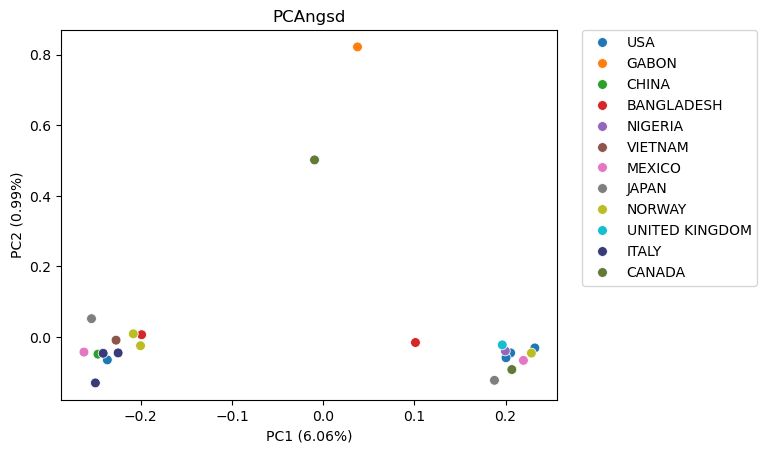

In [25]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Scomber_scombrus.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [26]:
bamlist[bamlist["PC2"] > 0.4]

,sample_id,sample_type,field_id,feed_pellet,intended_for,country,locality,manufacturer_country,manufacturer,formulation,...,manufacture_date,date_of_receipt,misc,notes,common_name,species,family,intended_for_latin,PC1,PC2
3,AF028,experimental,NaN,y,Tilapia,GABON,NaN,GABON,NaN,NaN,...,NaN,NaN,Not a lot of info| need more if possible. Says...,NaN,NaN,NaN,NaN,NaN,0.037659,0.822236
22,AF213,experimental,NaN,y,Atlantic salmon,CANADA,Newfoundland\n,CANADA,Skretting,Europa 9mm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009464,0.501876


In [27]:
bamlist = pd.read_csv("./Engraulis_ringens.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_276/53608508.py:12: UserWarning: 
The palette list has fewer values (14) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


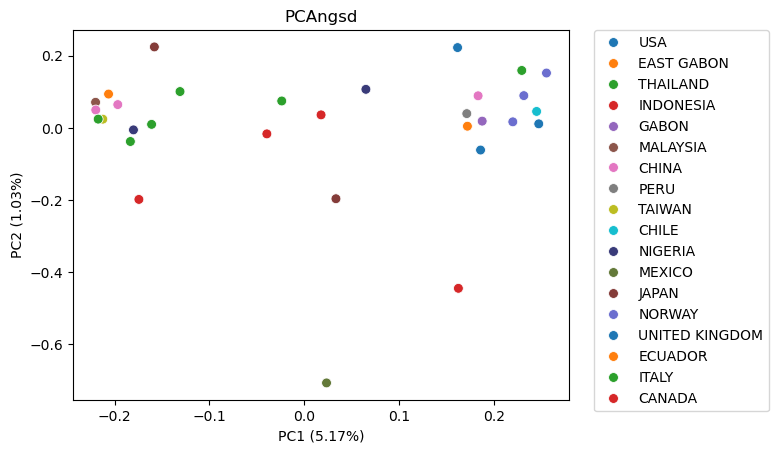

In [121]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Engraulis_ringens.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/tmp/ipykernel_192/931838504.py:12: UserWarning: 
The palette list has fewer values (14) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


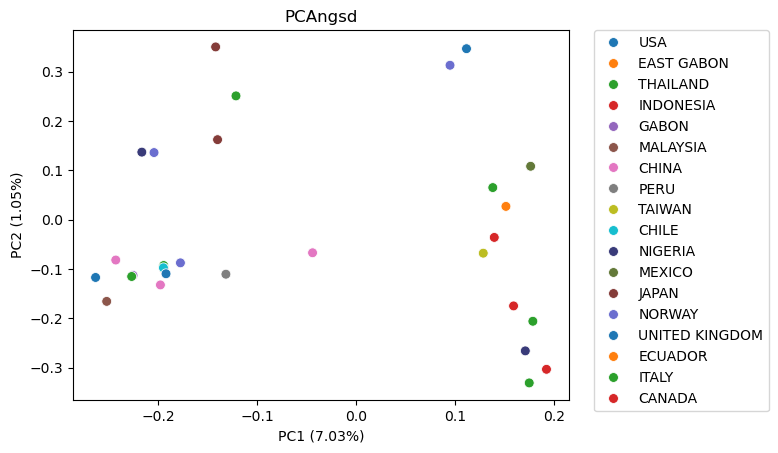

In [28]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Engraulis_ringens_bowtie.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [9]:
bamlist = pd.read_csv("./Engraulis_ringens_filtered.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_5688/2732912690.py:12: UserWarning: 
The palette list has fewer values (14) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


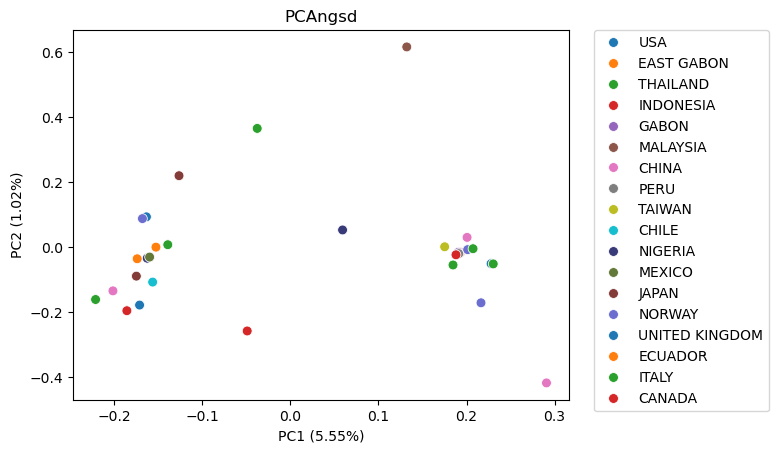

In [10]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Engraulis_ringens_filtered.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [11]:
bamlist = pd.read_csv("./Scomber_scombrus_filtered.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_5688/3449856815.py:12: UserWarning: The palette list has more values (14) than needed (12), which may not be intended.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


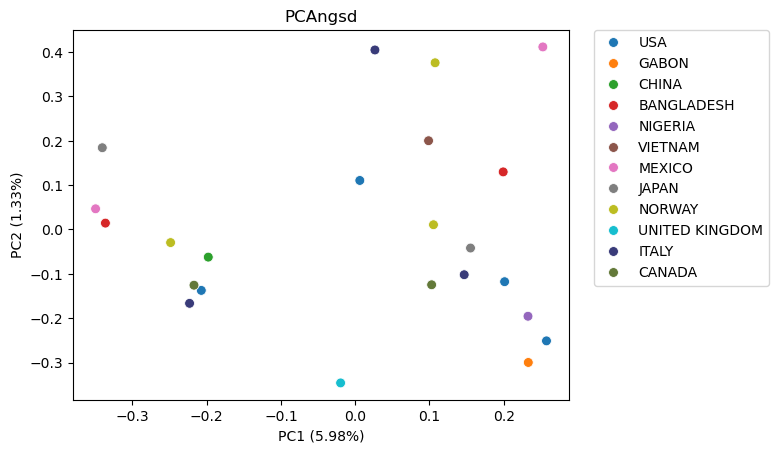

In [12]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Scomber_scombrus_filtered.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [13]:
bamlist = pd.read_csv("./Salmo_salar_filtered.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_5688/662819021.py:12: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


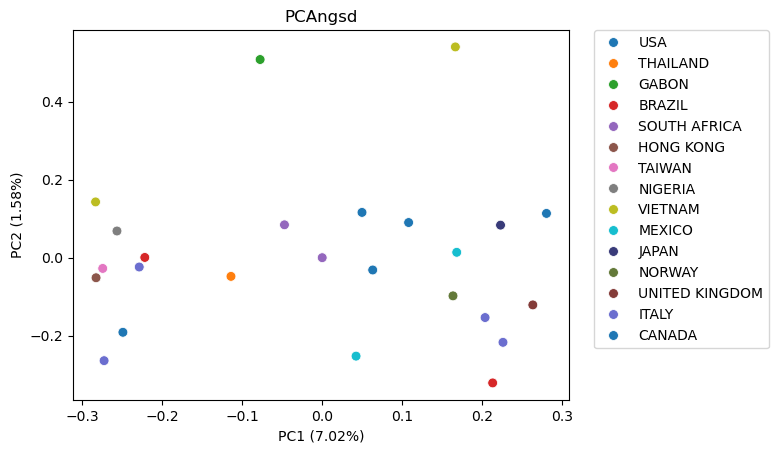

In [14]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Salmo_salar_filtered.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [15]:
bamlist = pd.read_csv("./Sardina_pilchardus_filtered.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_5688/2655474974.py:12: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


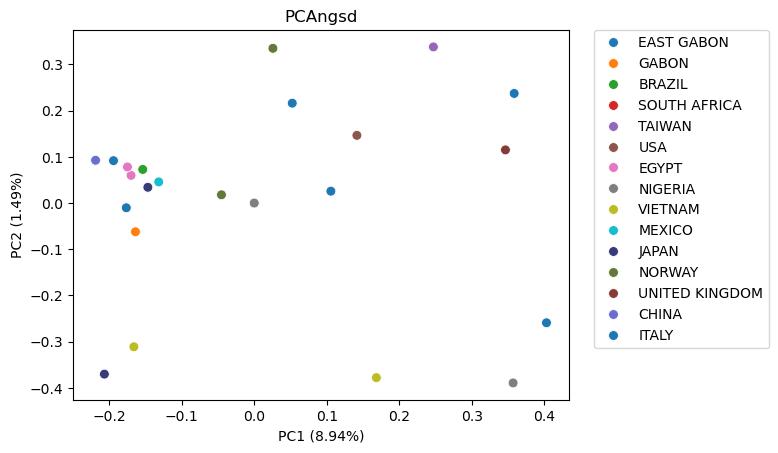

In [16]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Sardina_pilchardus_filtered.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [17]:
bamlist = pd.read_csv("./Micromesistius_poutassou_filtered.bamlist", header = None)
bamlist[0] = bamlist[0].str.split("/", expand = True)[2].str.split("_", n = 1, expand = True)[0]
bamlist.columns = ["sample_id"]
bamlist = bamlist.merge(metadata, how = "left", on = "sample_id")

/tmp/ipykernel_5688/4188903040.py:12: UserWarning: The palette list has more values (14) than needed (11), which may not be intended.
  sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)


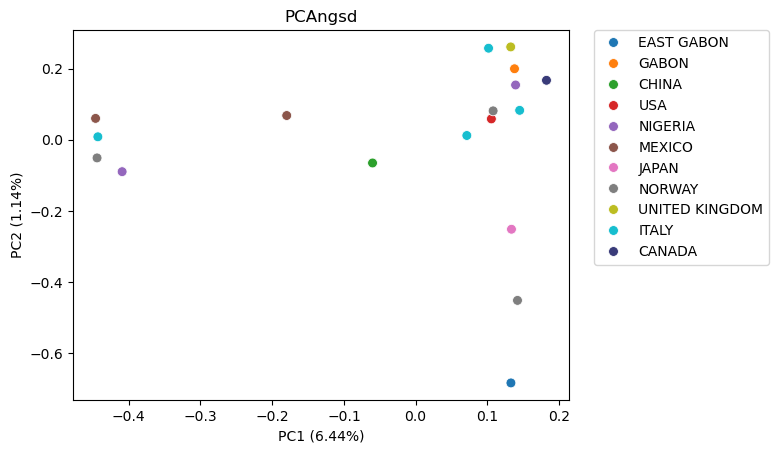

In [18]:
import matplotlib.pyplot as plt
import numpy as np
C = np.loadtxt("Micromesistius_poutassou_filtered.cov") # Reads estimated covariance matrix

# Plot PCA plot
evals, evecs = np.linalg.eigh(C)
evecs = evecs[:,::-1]

bamlist["PC1"] = evecs[:,0]
bamlist["PC2"] = evecs[:,1]

sns.scatterplot(data = bamlist, x = "PC1", y = "PC2", hue = "country", palette = distinct_palette, s = 50)
plt.xlabel("PC1 (" + str(round(evals[-1], 2)) + "%)")
plt.ylabel("PC2 (" + str(round(evals[-2], 2)) + "%)")
plt.title("PCAngsd")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [19]:
# Example: load from a file with two columns, no header
# df = pd.read_csv("your_file.txt", sep="\t", names=["CIGAR", "NM"])

# If you already have the DataFrame, skip loading
# Let's assume it's called `df` and has columns 'CIGAR' and 'NM'

def parse_cigar_ops(cigar):
    """Returns list of (length, op) tuples from a CIGAR string."""
    return [(int(length), op) for length, op in re.findall(r'(\d+)([MIDNSHP=X])', cigar)]

def calc_effective_identity(cigar, nm):
    ops = parse_cigar_ops(cigar)
    aligned = sum(length for length, op in ops if op in ('M', '=', 'X'))  # aligned bases
    read_len = sum(length for length, op in ops if op in ('M', '=', 'X', 'I', 'S'))  # full read length
    if read_len == 0:
        return 0.0  # avoid division by zero
    return (aligned - nm) / read_len

# Apply to each row

In [94]:
tmp = pd.read_csv("SRR2174357_Salmo_salar_Salmo_salar_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2018329
2000979
1315426
1167891


/tmp/ipykernel_125/3867684102.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [95]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    1105840
0.990099      62051
Name: count, dtype: int64

In [96]:
tmp = pd.read_csv("SRR2174369_Salmo_salar_Salmo_salar_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2006140
1978604
1301422
1176327


/tmp/ipykernel_125/407596231.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [97]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    1109873
0.990099      66454
Name: count, dtype: int64

In [98]:
tmp = pd.read_csv("SRR28213561_Salmo_salar_Salmo_salar_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2020577
2016154
1360450
1105533


/tmp/ipykernel_125/918957781.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [99]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    868195
0.993377    150297
0.993333     52465
0.993289     16876
0.993243      5958
0.993197      2077
0.993151       848
0.993103       556
0.993056       330
0.992754       307
0.992647       303
0.992857       293
0.992593       274
0.993007       269
0.992126       269
0.992701       265
0.992908       263
0.992806       257
0.992958       255
0.992063       252
0.992000       243
0.991935       227
0.992537       222
0.992481       212
0.992308       210
0.992424       206
0.992188       203
0.992366       203
0.991304       201
0.992248       196
0.990654       180
0.991228       177
0.991870       172
0.991525       172
0.991453       167
0.991379       157
0.990566       156
0.990385       141
0.990476       137
0.991667       135
0.991597       134
0.991150       119
0.991736       118
0.990291       116
0.991803       115
0.991071       107
0.990826       105
0.990099        99
0.990741        92
0.990991        85
0.990196        62
0.990909     

In [100]:
tmp = pd.read_csv("SRR28213561_Salmo_salar_Salmo_trutta_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2101779
2080540
1118330
219432


/tmp/ipykernel_125/2026497390.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [101]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
0.993377    85475
1.000000    82799
0.993333    29210
0.993289     9259
0.993243     3352
0.993197     1121
0.993151      438
0.993103      345
0.992000      241
0.991935      237
0.992754      232
0.992063      225
0.993056      224
0.992701      222
0.992806      217
0.992593      212
0.992647      211
0.991379      209
0.992537      202
0.992188      199
0.992857      199
0.992126      198
0.990566      196
0.992248      195
0.991453      192
0.992308      191
0.993007      183
0.991525      173
0.990654      170
0.991304      170
0.992908      163
0.991228      156
0.992958      154
0.990741      153
0.992424      151
0.991150      150
0.992481      150
0.991870      147
0.990385      142
0.992366      139
0.990291      133
0.991597      129
0.991071      127
0.990476      125
0.991803      124
0.991736      124
0.990909      122
0.991667      122
0.990196      116
0.990099      105
0.990991      104
0.990826       99
Name: count, dtype: int64

In [102]:
tmp = pd.read_csv("SRR28213561_Salmo_salar_Salvelinus_fontinalis_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2162329
2081997
870625
21391


/tmp/ipykernel_125/1275551258.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [103]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    9218
0.993377    6924
0.993333    2787
0.993289     825
0.993243     370
0.993197     106
0.993151      52
0.993056      37
0.991597      36
0.992188      35
0.990196      35
0.990826      34
0.991870      34
0.991379      34
0.991453      33
0.992063      33
0.990566      32
0.990476      32
0.992701      32
0.992908      31
0.990654      30
0.992126      29
0.991525      28
0.993007      27
0.992754      26
0.991150      26
0.991304      26
0.992424      25
0.990909      25
0.992857      25
0.990099      25
0.992000      24
0.990291      24
0.992248      24
0.992593      23
0.992806      23
0.993103      23
0.991071      23
0.990741      22
0.992481      21
0.992537      20
0.991935      20
0.992366      18
0.990385      18
0.991228      16
0.991736      15
0.992958      12
0.990991      12
0.992647      12
0.992308      11
0.991803      11
0.991667       7
Name: count, dtype: int64

In [104]:
tmp = pd.read_csv("SRR28213561_Salmo_salar_Scomber_scombrus_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2024073
830745
238912
439


/tmp/ipykernel_125/1521879981.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [105]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    216
0.993377    108
0.993333     48
0.993289     15
0.993243     11
0.992806      6
0.991150      4
0.991453      4
0.993151      3
0.992754      2
0.992908      2
0.992481      2
0.990291      2
0.992424      2
0.992248      2
0.992000      2
0.991667      2
0.990909      2
0.990741      2
0.993103      1
0.993197      1
0.991803      1
0.990196      1
Name: count, dtype: int64

In [70]:
tmp = pd.read_csv("ERR12302715_Scomber_scombrus_Scomber_scombrus_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2035560
2005856
1746951
1138937


/tmp/ipykernel_125/1256251159.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [71]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    825171
0.993377    187454
0.993333     90506
0.993289     24510
0.993243      7656
0.993197      1954
0.993151       422
0.993103       101
0.993056        64
0.992908        60
0.992958        44
0.993007        43
0.992188        41
0.992857        39
0.992000        34
0.991667        33
0.991935        33
0.990909        32
0.992537        31
0.992806        30
0.992063        30
0.991736        30
0.991597        29
0.992647        29
0.992701        27
0.992366        27
0.992593        25
0.992126        25
0.991453        25
0.990196        25
0.992308        24
0.992754        23
0.992424        23
0.990991        22
0.991379        21
0.990741        21
0.991803        21
0.991525        20
0.990654        20
0.992248        20
0.991304        19
0.990476        19
0.990566        18
0.991071        18
0.991870        17
0.990826        17
0.991228        16
0.990099        15
0.991150        14
0.992481        14
0.990385        14
0.990291     

In [72]:
tmp = pd.read_csv("SRR11679558_Scomber_scombrus_Scomber_scombrus_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2079671
2058609
1816966
1112089


/tmp/ipykernel_125/1459308071.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [73]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    828414
0.993377    131016
0.993333     77518
0.993289     22657
0.993243      9546
0.993197      4107
0.993151      2629
0.993103      1923
0.993056      1700
0.993007      1365
0.992958      1237
0.992908      1183
0.992857      1120
0.992806      1067
0.992754       982
0.992701       968
0.992481       959
0.992424       944
0.992537       935
0.992647       925
0.992366       925
0.992593       866
0.992248       805
0.991803       800
0.992308       792
0.992063       770
0.992000       766
0.992126       756
0.991597       739
0.991870       736
0.991935       717
0.992188       711
0.991667       692
0.991736       688
0.991525       687
0.991228       666
0.990991       651
0.991379       639
0.991071       625
0.991453       620
0.991304       619
0.991150       596
0.990909       563
0.990826       559
0.990291       553
0.990385       531
0.990741       518
0.990196       500
0.990476       478
0.990099       449
0.990566       439
0.990654     

In [74]:
tmp = pd.read_csv("SRR1766224_Scomber_scombrus_Scomber_scombrus_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2016621
1985091
1755223
1241788


/tmp/ipykernel_125/823865958.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [75]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    1074038
0.990099     167750
Name: count, dtype: int64

In [76]:
tmp = pd.read_csv("ERR12302715_Scomber_scombrus_Scomber_japonicus_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2139261
2028734
1538918
60403


/tmp/ipykernel_125/2985832924.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [77]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    25468
0.993377    21568
0.993333     9160
0.993289     2906
0.993243      891
0.993197      203
0.993151       41
0.993103       15
0.990099       10
0.991736        9
0.991150        8
0.990566        7
0.993056        7
0.992701        7
0.992188        6
0.990476        6
0.992958        6
0.991803        6
0.992857        6
0.992537        5
0.990291        4
0.993007        4
0.992806        4
0.990909        4
0.991228        4
0.992126        4
0.992908        3
0.992754        3
0.991379        3
0.991525        3
0.991870        3
0.992481        3
0.992424        3
0.992063        2
0.991935        2
0.992308        2
0.991667        2
0.990991        2
0.990826        2
0.990385        2
0.990196        2
0.992647        1
0.992593        1
0.991597        1
0.990741        1
0.990654        1
0.991453        1
0.992366        1
Name: count, dtype: int64

In [78]:
tmp = pd.read_csv("ERR12302715_Scomber_scombrus_Scomber_colias_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2138699
2014115
1522645
61028


/tmp/ipykernel_125/1223161838.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [79]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    25636
0.993377    21840
0.993333     9320
0.993289     2934
0.993243      870
0.993197      213
0.993151       33
0.993103       18
0.992701        9
0.991736        8
0.992857        7
0.992188        7
0.991150        7
0.990826        6
0.990476        6
0.992958        6
0.990196        5
0.992754        5
0.990991        5
0.993007        5
0.992308        5
0.992806        5
0.990566        5
0.993056        4
0.991870        4
0.991803        4
0.991667        4
0.992481        4
0.992537        4
0.992908        4
0.992647        4
0.990099        4
0.990909        3
0.990741        3
0.991228        3
0.991379        3
0.992424        3
0.992366        3
0.991935        3
0.991597        3
0.991525        3
0.992063        2
0.990385        2
0.990291        2
0.992593        2
0.990654        1
0.991453        1
Name: count, dtype: int64

In [80]:
tmp = pd.read_csv("ERR12302715_Scomber_scombrus_Thunnus_thynnus_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2062672
1442320
994303
9404


/tmp/ipykernel_125/1940232007.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [81]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    4411
0.993377    3083
0.993333    1289
0.993289     441
0.993243     123
0.993197      14
0.993151       7
0.992126       5
0.992188       4
0.993103       4
0.992754       3
0.993056       2
0.990099       2
0.990654       2
0.992308       2
0.991870       2
0.991150       2
0.990741       2
0.992647       2
0.992958       1
0.992000       1
0.991597       1
0.990909       1
Name: count, dtype: int64

In [82]:
tmp = pd.read_csv("ERR12302715_Scomber_scombrus_Salmo_salar_markdup.nm.txt", sep = "\t", header = None)
print(len(tmp))
tmp = tmp[tmp[1] != "*"].reset_index(drop=True)
print(len(tmp))
print(len(tmp[tmp[0] > 30]))
tmp[2] = tmp[2].str.replace("NM:i:", "").astype(int)
tmp["EffectiveIdentity"] = tmp.apply(lambda row: calc_effective_identity(row[1], row[2]), axis=1)
print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))

2009305
354231
71092
141


/tmp/ipykernel_125/1348374754.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30]))


In [83]:
tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")

/tmp/ipykernel_125/2462796827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp[tmp["EffectiveIdentity"] > 0.99][tmp[0] > 30].value_counts("EffectiveIdentity")


EffectiveIdentity
1.000000    82
0.993377    39
0.993289     7
0.993243     5
0.993333     3
0.991736     1
0.992126     1
0.992857     1
0.993151     1
0.993197     1
Name: count, dtype: int64

In [88]:
tmp = pd.read_csv("ncbi_dataset.tsv", sep = "\t")

In [90]:
tmp = tmp.drop_duplicates("Organism Taxonomic ID").reset_index(drop=True)

In [93]:
tmp['Assembly Stats Total Sequence Length'].sum() / 1000000000000

5.116595211682